## Import packages you need


In [1]:
# Import necessary packages.
import os
import copy
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as scheduler
import torchvision.transforms as transforms
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, TensorDataset, Dataset
from torchvision.datasets import DatasetFolder

# If you haven't download the tqdm package, just uncomment the following line.
#!pip install tqdm
# This is for the progress bar.
from tqdm.auto import tqdm


/home/alex/miniconda3/envs/4016/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Show current device name


In [2]:
torch.cuda.get_device_name(0)


'NVIDIA GeForce RTX 3080 Ti'

## Dataset, Data Loader, and Transforms


In [3]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.RandomResizedCrop((128, 128)),
    # transforms.RandomCrop(size=128, padding=10),

    # Randomly flip and rotate the image
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomInvert(),

    # Randomly adjust the brightness and contrast of the image
    transforms.ColorJitter((0.875, 1.125), (0.5, 1.5), (0.5, 1.5), (-0.05, 0.05)),
    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=(-10, 10, -10, 10)),

    # Convert the image to a tensor
    transforms.RandAugment(),
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 48

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("../data/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("../data/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("../data/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("../data/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


## Training


In [4]:
class PseudoDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, id):
        return self.x[id][0], self.y[id]


In [5]:
def get_pseudo_labels(dataset, model, threshold):
    # This functions generates pseudo-label of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    index = []
    label = []

    for i, batch in enumerate(tqdm(dataloader)):
        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)

        # you may filter the data and construct a new dataset here.
        for j, x in enumerate(probs):
            if torch.max(x) > threshold:
                index.append(i * batch_size + j)
                label.append(int(torch.argmax(x)))

    # Turn off the eval mode.
    model.train()
    return PseudoDataset(Subset(dataset, index), label)


In [6]:
def model_snapshot(model, new_file=None, old_file=None):
    if os.path.exists(old_file) is True:
        os.remove(old_file)
    torch.save(model, new_file)


In [7]:
def train_model(model, n_epochs, do_semi, device, batch_size, criterion, optimizer, scheduler, train_loader, valid_loader, train_set, unlabeled_set):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_acc = 0.
    best_loss = 100.
    best_epoch = 0
    best_model = None
    acc_threshold = 0.70
    pseudo_threshold = 0.95
    ending_threshold = 100

    for epoch in range(n_epochs):
        # ---------- TODO ----------
        # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
        # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
        if do_semi and best_acc > acc_threshold:
            # Obtain pseudo-labels for unlabeled data using trained model.
            pseudo_set = get_pseudo_labels(unlabeled_set, model, pseudo_threshold)

            # Construct a new dataset and a data loader for training.
            # This is used in semi-supervised learning only.
            concat_dataset = ConcatDataset([train_set, pseudo_set])
            train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []

        # Iterate the training set by batches.
        for batch in tqdm(train_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # Forward the data. (Make sure data and model are on the same device.)
            logits = model(imgs.to(device))

            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels.to(device))

            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)

        # The average loss and accuracy of the training set is the average of the recorded values.
        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        for batch in tqdm(valid_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(device))

            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(device))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        # Update the scheduler.
        scheduler.step(valid_acc)

        # Save the loss and accuracy for each epoch.
        history["train_loss"].append(train_loss)
        history["val_loss"].append(valid_loss)
        history["train_acc"].append(train_acc.cpu())
        history["val_acc"].append(valid_acc.cpu())

        # Dont ask, this is the only way to round the number for some reason
        if float(f"{valid_acc:.5f}") >= float(f"{best_acc:.5f}") and round(valid_loss, 5) < round(best_loss, 5):
            model_snapshot(model.state_dict(), new_file=f"{epoch + 1}_{valid_acc}.pth", old_file=f"{best_epoch + 1}_{best_acc}.pth")
            best_acc = valid_acc
            best_loss = valid_loss
            best_epoch = epoch
            best_model = copy.deepcopy(model)

        # Print the information.
        print(f"[Train | {epoch + 1:03d}/{n_epochs:03d}] loss = {train_loss:.5f}, acc = {train_acc:.5f}, lr = {optimizer.param_groups[-1]['lr']}")
        print(f"[Valid | {epoch + 1:03d}/{n_epochs:03d}][Best | {best_epoch + 1}] loss = {valid_loss:.5f}[{best_loss:.5f}], acc = {valid_acc:.5f}[{best_acc:.5f}]")

        if epoch - best_epoch >= ending_threshold:
            break

    # Return model and history for later use.
    return best_model, history


In [8]:
def concat_history(history1: dict, history2: dict):
    for key in history1.keys() & history2.keys():
        history1[key] = history1[key] + history2[key]


In [9]:
def plot_loss(history):
    plt.plot([*range(1, len(history["train_loss"]) + 1)], history["train_loss"])
    plt.plot([*range(1, len(history["val_loss"]) + 1)], history["val_loss"])
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.legend(labels=["Train", "Validation"])


In [10]:
def plot_acc(history):
    plt.plot([*range(1, len(history["train_acc"]) + 1)], history["train_acc"])
    plt.plot([*range(1, len(history["val_acc"]) + 1)], history["val_acc"])
    plt.xlabel("Epoches")
    plt.ylabel("Accuracy")
    plt.legend(labels=["Train", "Validation"])


In [11]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = torchvision.models.efficientnet_v2_l(weights=None).to(device)
# model_path = "model/name/path.pth"
# model.load_state_dict(torch.load(model_path, map_location="cuda"))
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=50, threshold=1e-3, verbose=True)

# The number of training epochs.
n_epochs = 2000

# Whether to do semi-supervised learning.
do_semi = True

# Save history of accuracy and loss.
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}


In [12]:
bestd_model, train_history = train_model(model, n_epochs, do_semi, device, batch_size, criterion, optimizer, scheduler, train_loader, valid_loader, train_set, unlabeled_set)
concat_history(history, train_history)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 001/2000] loss = 5.17474, acc = 0.09488, lr = 0.0003
[Valid | 001/2000][Best | 1] loss = 3.31425[3.31425], acc = 0.08978[0.08978]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 002/2000] loss = 2.54856, acc = 0.10205, lr = 0.0003
[Valid | 002/2000][Best | 2] loss = 2.49383[2.49383], acc = 0.09325[0.09325]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 003/2000] loss = 2.49443, acc = 0.09060, lr = 0.0003
[Valid | 003/2000][Best | 2] loss = 2.44640[2.49383], acc = 0.08532[0.09325]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 004/2000] loss = 2.46015, acc = 0.08752, lr = 0.0003
[Valid | 004/2000][Best | 4] loss = 2.41836[2.41836], acc = 0.10962[0.10962]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 005/2000] loss = 2.44424, acc = 0.08888, lr = 0.0003
[Valid | 005/2000][Best | 4] loss = 2.41460[2.41836], acc = 0.09028[0.10962]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 006/2000] loss = 2.42946, acc = 0.08419, lr = 0.0003
[Valid | 006/2000][Best | 4] loss = 2.40561[2.41836], acc = 0.10069[0.10962]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 007/2000] loss = 2.42124, acc = 0.09383, lr = 0.0003
[Valid | 007/2000][Best | 7] loss = 2.40266[2.40266], acc = 0.11954[0.11954]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 008/2000] loss = 2.41781, acc = 0.10326, lr = 0.0003
[Valid | 008/2000][Best | 7] loss = 2.38684[2.40266], acc = 0.10367[0.11954]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 009/2000] loss = 2.41713, acc = 0.09408, lr = 0.0003
[Valid | 009/2000][Best | 7] loss = 2.41151[2.40266], acc = 0.10714[0.11954]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 010/2000] loss = 2.40613, acc = 0.09867, lr = 0.0003
[Valid | 010/2000][Best | 10] loss = 2.36811[2.36811], acc = 0.13294[0.13294]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 011/2000] loss = 2.39737, acc = 0.11360, lr = 0.0003
[Valid | 011/2000][Best | 11] loss = 2.35576[2.35576], acc = 0.13839[0.13839]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 012/2000] loss = 2.39871, acc = 0.11254, lr = 0.0003
[Valid | 012/2000][Best | 11] loss = 2.36863[2.35576], acc = 0.12103[0.13839]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 013/2000] loss = 2.39010, acc = 0.11168, lr = 0.0003
[Valid | 013/2000][Best | 11] loss = 2.40604[2.35576], acc = 0.10813[0.13839]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 014/2000] loss = 2.39905, acc = 0.11244, lr = 0.0003
[Valid | 014/2000][Best | 11] loss = 2.36803[2.35576], acc = 0.10714[0.13839]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 015/2000] loss = 2.40097, acc = 0.10810, lr = 0.0003
[Valid | 015/2000][Best | 11] loss = 2.37539[2.35576], acc = 0.13690[0.13839]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 016/2000] loss = 2.38870, acc = 0.11062, lr = 0.0003
[Valid | 016/2000][Best | 11] loss = 2.38512[2.35576], acc = 0.13046[0.13839]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 017/2000] loss = 2.38301, acc = 0.12218, lr = 0.0003
[Valid | 017/2000][Best | 17] loss = 2.34509[2.34509], acc = 0.13988[0.13988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 018/2000] loss = 2.38778, acc = 0.11945, lr = 0.0003
[Valid | 018/2000][Best | 17] loss = 2.35575[2.34509], acc = 0.13046[0.13988]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 019/2000] loss = 2.38357, acc = 0.11920, lr = 0.0003
[Valid | 019/2000][Best | 19] loss = 2.33610[2.33610], acc = 0.14236[0.14236]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 020/2000] loss = 2.37162, acc = 0.12707, lr = 0.0003
[Valid | 020/2000][Best | 19] loss = 2.33446[2.33610], acc = 0.12054[0.14236]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 021/2000] loss = 2.37530, acc = 0.12313, lr = 0.0003
[Valid | 021/2000][Best | 21] loss = 2.32134[2.32134], acc = 0.14286[0.14286]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 022/2000] loss = 2.36599, acc = 0.13065, lr = 0.0003
[Valid | 022/2000][Best | 21] loss = 2.36503[2.32134], acc = 0.13690[0.14286]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 023/2000] loss = 2.37190, acc = 0.12379, lr = 0.0003
[Valid | 023/2000][Best | 21] loss = 2.33137[2.32134], acc = 0.15030[0.14286]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 024/2000] loss = 2.37013, acc = 0.12888, lr = 0.0003
[Valid | 024/2000][Best | 21] loss = 2.31152[2.32134], acc = 0.13641[0.14286]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 025/2000] loss = 2.37529, acc = 0.12641, lr = 0.0003
[Valid | 025/2000][Best | 25] loss = 2.28419[2.28419], acc = 0.16171[0.16171]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 026/2000] loss = 2.37898, acc = 0.12318, lr = 0.0003
[Valid | 026/2000][Best | 25] loss = 2.29718[2.28419], acc = 0.15427[0.16171]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 027/2000] loss = 2.36191, acc = 0.14079, lr = 0.0003
[Valid | 027/2000][Best | 25] loss = 2.30960[2.28419], acc = 0.18601[0.16171]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 028/2000] loss = 2.36180, acc = 0.14119, lr = 0.0003
[Valid | 028/2000][Best | 25] loss = 2.30530[2.28419], acc = 0.16766[0.16171]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 029/2000] loss = 2.35580, acc = 0.13690, lr = 0.0003
[Valid | 029/2000][Best | 25] loss = 2.30684[2.28419], acc = 0.15724[0.16171]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 030/2000] loss = 2.35645, acc = 0.14165, lr = 0.0003
[Valid | 030/2000][Best | 25] loss = 2.30436[2.28419], acc = 0.15675[0.16171]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 031/2000] loss = 2.35954, acc = 0.13353, lr = 0.0003
[Valid | 031/2000][Best | 25] loss = 2.28821[2.28419], acc = 0.16567[0.16171]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 032/2000] loss = 2.34313, acc = 0.15254, lr = 0.0003
[Valid | 032/2000][Best | 25] loss = 2.29485[2.28419], acc = 0.18998[0.16171]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 033/2000] loss = 2.34935, acc = 0.14190, lr = 0.0003
[Valid | 033/2000][Best | 25] loss = 2.28208[2.28419], acc = 0.15030[0.16171]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 034/2000] loss = 2.35930, acc = 0.14472, lr = 0.0003
[Valid | 034/2000][Best | 34] loss = 2.27176[2.27176], acc = 0.19494[0.19494]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 035/2000] loss = 2.34181, acc = 0.15602, lr = 0.0003
[Valid | 035/2000][Best | 34] loss = 2.27989[2.27176], acc = 0.17460[0.19494]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 036/2000] loss = 2.32872, acc = 0.15552, lr = 0.0003
[Valid | 036/2000][Best | 34] loss = 2.28512[2.27176], acc = 0.16071[0.19494]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 037/2000] loss = 2.34165, acc = 0.14482, lr = 0.0003
[Valid | 037/2000][Best | 34] loss = 2.31731[2.27176], acc = 0.13988[0.19494]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 038/2000] loss = 2.34292, acc = 0.14366, lr = 0.0003
[Valid | 038/2000][Best | 34] loss = 2.28047[2.27176], acc = 0.18601[0.19494]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 039/2000] loss = 2.33548, acc = 0.15380, lr = 0.0003
[Valid | 039/2000][Best | 39] loss = 2.26515[2.26515], acc = 0.20734[0.20734]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 040/2000] loss = 2.32757, acc = 0.16414, lr = 0.0003
[Valid | 040/2000][Best | 39] loss = 2.24601[2.26515], acc = 0.18304[0.20734]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 041/2000] loss = 2.33613, acc = 0.15027, lr = 0.0003
[Valid | 041/2000][Best | 39] loss = 2.27197[2.26515], acc = 0.17609[0.20734]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 042/2000] loss = 2.33178, acc = 0.15174, lr = 0.0003
[Valid | 042/2000][Best | 39] loss = 2.22628[2.26515], acc = 0.19246[0.20734]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 043/2000] loss = 2.32752, acc = 0.15471, lr = 0.0003
[Valid | 043/2000][Best | 39] loss = 2.24288[2.26515], acc = 0.18849[0.20734]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 044/2000] loss = 2.33058, acc = 0.14992, lr = 0.0003
[Valid | 044/2000][Best | 39] loss = 2.25919[2.26515], acc = 0.18403[0.20734]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 045/2000] loss = 2.32800, acc = 0.16293, lr = 0.0003
[Valid | 045/2000][Best | 45] loss = 2.24701[2.24701], acc = 0.22520[0.22520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 046/2000] loss = 2.30914, acc = 0.16687, lr = 0.0003
[Valid | 046/2000][Best | 45] loss = 2.24750[2.24701], acc = 0.17758[0.22520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 047/2000] loss = 2.33073, acc = 0.15532, lr = 0.0003
[Valid | 047/2000][Best | 45] loss = 2.25422[2.24701], acc = 0.19345[0.22520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 048/2000] loss = 2.31932, acc = 0.16631, lr = 0.0003
[Valid | 048/2000][Best | 45] loss = 2.23104[2.24701], acc = 0.20040[0.22520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 049/2000] loss = 2.31579, acc = 0.16208, lr = 0.0003
[Valid | 049/2000][Best | 45] loss = 2.23083[2.24701], acc = 0.17758[0.22520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 050/2000] loss = 2.30408, acc = 0.17186, lr = 0.0003
[Valid | 050/2000][Best | 45] loss = 2.19522[2.24701], acc = 0.20139[0.22520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 051/2000] loss = 2.31363, acc = 0.16112, lr = 0.0003
[Valid | 051/2000][Best | 45] loss = 2.23337[2.24701], acc = 0.17312[0.22520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 052/2000] loss = 2.32796, acc = 0.15834, lr = 0.0003
[Valid | 052/2000][Best | 45] loss = 2.20731[2.24701], acc = 0.17212[0.22520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 053/2000] loss = 2.31549, acc = 0.15880, lr = 0.0003
[Valid | 053/2000][Best | 45] loss = 2.23154[2.24701], acc = 0.19296[0.22520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 054/2000] loss = 2.30379, acc = 0.15703, lr = 0.0003
[Valid | 054/2000][Best | 45] loss = 2.21472[2.24701], acc = 0.20288[0.22520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 055/2000] loss = 2.29715, acc = 0.17257, lr = 0.0003
[Valid | 055/2000][Best | 55] loss = 2.18112[2.18112], acc = 0.22768[0.22768]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 056/2000] loss = 2.29776, acc = 0.17701, lr = 0.0003
[Valid | 056/2000][Best | 55] loss = 2.24922[2.18112], acc = 0.16716[0.22768]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 057/2000] loss = 2.28078, acc = 0.17544, lr = 0.0003
[Valid | 057/2000][Best | 55] loss = 2.15395[2.18112], acc = 0.22024[0.22768]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 058/2000] loss = 2.27816, acc = 0.18725, lr = 0.0003
[Valid | 058/2000][Best | 55] loss = 2.20417[2.18112], acc = 0.21776[0.22768]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 059/2000] loss = 2.30998, acc = 0.16672, lr = 0.0003
[Valid | 059/2000][Best | 55] loss = 2.23930[2.18112], acc = 0.21280[0.22768]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 060/2000] loss = 2.28437, acc = 0.17479, lr = 0.0003
[Valid | 060/2000][Best | 55] loss = 2.19084[2.18112], acc = 0.18502[0.22768]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 061/2000] loss = 2.28731, acc = 0.16657, lr = 0.0003
[Valid | 061/2000][Best | 55] loss = 2.24014[2.18112], acc = 0.17163[0.22768]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 062/2000] loss = 2.28419, acc = 0.17045, lr = 0.0003
[Valid | 062/2000][Best | 55] loss = 2.23797[2.18112], acc = 0.23065[0.22768]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 063/2000] loss = 2.26707, acc = 0.18054, lr = 0.0003
[Valid | 063/2000][Best | 55] loss = 2.23293[2.18112], acc = 0.19494[0.22768]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 064/2000] loss = 2.28189, acc = 0.17948, lr = 0.0003
[Valid | 064/2000][Best | 55] loss = 2.18230[2.18112], acc = 0.22321[0.22768]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 065/2000] loss = 2.26725, acc = 0.18210, lr = 0.0003
[Valid | 065/2000][Best | 65] loss = 2.12068[2.12068], acc = 0.25794[0.25794]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 066/2000] loss = 2.26049, acc = 0.18730, lr = 0.0003
[Valid | 066/2000][Best | 65] loss = 2.25589[2.12068], acc = 0.17808[0.25794]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 067/2000] loss = 2.27390, acc = 0.18084, lr = 0.0003
[Valid | 067/2000][Best | 65] loss = 2.15392[2.12068], acc = 0.20188[0.25794]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 068/2000] loss = 2.26217, acc = 0.17560, lr = 0.0003
[Valid | 068/2000][Best | 65] loss = 2.20326[2.12068], acc = 0.22024[0.25794]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 069/2000] loss = 2.25000, acc = 0.19381, lr = 0.0003
[Valid | 069/2000][Best | 65] loss = 2.11281[2.12068], acc = 0.23909[0.25794]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 070/2000] loss = 2.24907, acc = 0.18543, lr = 0.0003
[Valid | 070/2000][Best | 65] loss = 2.12164[2.12068], acc = 0.23810[0.25794]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 071/2000] loss = 2.24217, acc = 0.18932, lr = 0.0003
[Valid | 071/2000][Best | 65] loss = 2.18279[2.12068], acc = 0.20437[0.25794]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 072/2000] loss = 2.24402, acc = 0.19507, lr = 0.0003
[Valid | 072/2000][Best | 72] loss = 2.09087[2.09087], acc = 0.26290[0.26290]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 073/2000] loss = 2.23767, acc = 0.18846, lr = 0.0003
[Valid | 073/2000][Best | 72] loss = 2.11047[2.09087], acc = 0.24454[0.26290]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 074/2000] loss = 2.24022, acc = 0.18715, lr = 0.0003
[Valid | 074/2000][Best | 72] loss = 2.15126[2.09087], acc = 0.23760[0.26290]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 075/2000] loss = 2.23443, acc = 0.19123, lr = 0.0003
[Valid | 075/2000][Best | 72] loss = 2.13685[2.09087], acc = 0.21131[0.26290]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 076/2000] loss = 2.22134, acc = 0.19895, lr = 0.0003
[Valid | 076/2000][Best | 72] loss = 2.10368[2.09087], acc = 0.24504[0.26290]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 077/2000] loss = 2.22688, acc = 0.19507, lr = 0.0003
[Valid | 077/2000][Best | 72] loss = 2.04310[2.09087], acc = 0.25992[0.26290]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 078/2000] loss = 2.19173, acc = 0.20460, lr = 0.0003
[Valid | 078/2000][Best | 72] loss = 2.10263[2.09087], acc = 0.22619[0.26290]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 079/2000] loss = 2.20106, acc = 0.21050, lr = 0.0003
[Valid | 079/2000][Best | 72] loss = 2.08644[2.09087], acc = 0.24950[0.26290]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 080/2000] loss = 2.18986, acc = 0.20339, lr = 0.0003
[Valid | 080/2000][Best | 72] loss = 2.09088[2.09087], acc = 0.23016[0.26290]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 081/2000] loss = 2.20262, acc = 0.19678, lr = 0.0003
[Valid | 081/2000][Best | 81] loss = 2.05826[2.05826], acc = 0.28571[0.28571]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 082/2000] loss = 2.19739, acc = 0.20818, lr = 0.0003
[Valid | 082/2000][Best | 81] loss = 2.07226[2.05826], acc = 0.23760[0.28571]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 083/2000] loss = 2.18137, acc = 0.21772, lr = 0.0003
[Valid | 083/2000][Best | 81] loss = 2.08557[2.05826], acc = 0.24107[0.28571]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 084/2000] loss = 2.19340, acc = 0.21640, lr = 0.0003
[Valid | 084/2000][Best | 81] loss = 2.06092[2.05826], acc = 0.24702[0.28571]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 085/2000] loss = 2.21360, acc = 0.20167, lr = 0.0003
[Valid | 085/2000][Best | 81] loss = 2.04218[2.05826], acc = 0.26389[0.28571]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 086/2000] loss = 2.18718, acc = 0.21681, lr = 0.0003
[Valid | 086/2000][Best | 81] loss = 2.03880[2.05826], acc = 0.24058[0.28571]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 087/2000] loss = 2.18132, acc = 0.21529, lr = 0.0003
[Valid | 087/2000][Best | 81] loss = 1.97127[2.05826], acc = 0.28274[0.28571]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 088/2000] loss = 2.18572, acc = 0.20470, lr = 0.0003
[Valid | 088/2000][Best | 81] loss = 2.01594[2.05826], acc = 0.27827[0.28571]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 089/2000] loss = 2.17470, acc = 0.22231, lr = 0.0003
[Valid | 089/2000][Best | 81] loss = 2.03525[2.05826], acc = 0.26835[0.28571]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 090/2000] loss = 2.15586, acc = 0.22735, lr = 0.0003
[Valid | 090/2000][Best | 90] loss = 2.00099[2.00099], acc = 0.28869[0.28869]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 091/2000] loss = 2.15814, acc = 0.22084, lr = 0.0003
[Valid | 091/2000][Best | 90] loss = 2.00330[2.00099], acc = 0.27381[0.28869]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 092/2000] loss = 2.17451, acc = 0.22115, lr = 0.0003
[Valid | 092/2000][Best | 90] loss = 2.01979[2.00099], acc = 0.28571[0.28869]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 093/2000] loss = 2.16121, acc = 0.22735, lr = 0.0003
[Valid | 093/2000][Best | 90] loss = 2.00659[2.00099], acc = 0.28770[0.28869]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 094/2000] loss = 2.14310, acc = 0.23002, lr = 0.0003
[Valid | 094/2000][Best | 90] loss = 1.99928[2.00099], acc = 0.26637[0.28869]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 095/2000] loss = 2.14335, acc = 0.22266, lr = 0.0003
[Valid | 095/2000][Best | 90] loss = 2.01788[2.00099], acc = 0.27381[0.28869]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 096/2000] loss = 2.14709, acc = 0.22513, lr = 0.0003
[Valid | 096/2000][Best | 90] loss = 2.06725[2.00099], acc = 0.25942[0.28869]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 097/2000] loss = 2.14070, acc = 0.24405, lr = 0.0003
[Valid | 097/2000][Best | 90] loss = 1.98593[2.00099], acc = 0.28819[0.28869]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 098/2000] loss = 2.16027, acc = 0.22448, lr = 0.0003
[Valid | 098/2000][Best | 90] loss = 2.00838[2.00099], acc = 0.26835[0.28869]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 099/2000] loss = 2.13577, acc = 0.23648, lr = 0.0003
[Valid | 099/2000][Best | 90] loss = 2.03478[2.00099], acc = 0.26240[0.28869]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 100/2000] loss = 2.12968, acc = 0.23739, lr = 0.0003
[Valid | 100/2000][Best | 90] loss = 2.04320[2.00099], acc = 0.26885[0.28869]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 101/2000] loss = 2.13117, acc = 0.25333, lr = 0.0003
[Valid | 101/2000][Best | 101] loss = 2.00096[2.00096], acc = 0.29663[0.29663]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 102/2000] loss = 2.12241, acc = 0.25615, lr = 0.0003
[Valid | 102/2000][Best | 101] loss = 1.99365[2.00096], acc = 0.28671[0.29663]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 103/2000] loss = 2.12682, acc = 0.23880, lr = 0.0003
[Valid | 103/2000][Best | 103] loss = 1.96178[1.96178], acc = 0.30804[0.30804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 104/2000] loss = 2.10289, acc = 0.25111, lr = 0.0003
[Valid | 104/2000][Best | 103] loss = 1.96891[1.96178], acc = 0.31597[0.30804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 105/2000] loss = 2.13636, acc = 0.25318, lr = 0.0003
[Valid | 105/2000][Best | 103] loss = 2.01135[1.96178], acc = 0.27728[0.30804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 106/2000] loss = 2.12323, acc = 0.24531, lr = 0.0003
[Valid | 106/2000][Best | 106] loss = 1.94443[1.94443], acc = 0.31746[0.31746]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 107/2000] loss = 2.12073, acc = 0.25015, lr = 0.0003
[Valid | 107/2000][Best | 106] loss = 1.98489[1.94443], acc = 0.30853[0.31746]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 108/2000] loss = 2.11601, acc = 0.25646, lr = 0.0003
[Valid | 108/2000][Best | 106] loss = 1.97213[1.94443], acc = 0.30010[0.31746]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 109/2000] loss = 2.11350, acc = 0.24324, lr = 0.0003
[Valid | 109/2000][Best | 106] loss = 1.95890[1.94443], acc = 0.30407[0.31746]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 110/2000] loss = 2.10597, acc = 0.25585, lr = 0.0003
[Valid | 110/2000][Best | 106] loss = 1.99926[1.94443], acc = 0.27679[0.31746]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 111/2000] loss = 2.08515, acc = 0.25620, lr = 0.0003
[Valid | 111/2000][Best | 106] loss = 2.03378[1.94443], acc = 0.25992[0.31746]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 112/2000] loss = 2.12316, acc = 0.24919, lr = 0.0003
[Valid | 112/2000][Best | 106] loss = 1.96325[1.94443], acc = 0.29960[0.31746]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 113/2000] loss = 2.11617, acc = 0.24047, lr = 0.0003
[Valid | 113/2000][Best | 106] loss = 1.96881[1.94443], acc = 0.30655[0.31746]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 114/2000] loss = 2.10504, acc = 0.25515, lr = 0.0003
[Valid | 114/2000][Best | 106] loss = 1.94449[1.94443], acc = 0.31944[0.31746]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 115/2000] loss = 2.09671, acc = 0.24874, lr = 0.0003
[Valid | 115/2000][Best | 106] loss = 1.99515[1.94443], acc = 0.30258[0.31746]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 116/2000] loss = 2.08897, acc = 0.25782, lr = 0.0003
[Valid | 116/2000][Best | 106] loss = 2.00082[1.94443], acc = 0.28819[0.31746]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 117/2000] loss = 2.07409, acc = 0.25499, lr = 0.0003
[Valid | 117/2000][Best | 106] loss = 1.94922[1.94443], acc = 0.30159[0.31746]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 118/2000] loss = 2.09156, acc = 0.24112, lr = 0.0003
[Valid | 118/2000][Best | 106] loss = 1.95105[1.94443], acc = 0.30109[0.31746]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 119/2000] loss = 2.09533, acc = 0.25545, lr = 0.0003
[Valid | 119/2000][Best | 119] loss = 1.94134[1.94134], acc = 0.32937[0.32937]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 120/2000] loss = 2.08092, acc = 0.25580, lr = 0.0003
[Valid | 120/2000][Best | 120] loss = 1.93723[1.93723], acc = 0.34226[0.34226]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 121/2000] loss = 2.03517, acc = 0.28627, lr = 0.0003
[Valid | 121/2000][Best | 120] loss = 1.90768[1.93723], acc = 0.32391[0.34226]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 122/2000] loss = 2.07604, acc = 0.26251, lr = 0.0003
[Valid | 122/2000][Best | 120] loss = 1.95034[1.93723], acc = 0.30556[0.34226]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 123/2000] loss = 2.05546, acc = 0.27381, lr = 0.0003
[Valid | 123/2000][Best | 120] loss = 1.88121[1.93723], acc = 0.33829[0.34226]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 124/2000] loss = 2.06281, acc = 0.27482, lr = 0.0003
[Valid | 124/2000][Best | 120] loss = 1.91668[1.93723], acc = 0.32738[0.34226]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 125/2000] loss = 2.07354, acc = 0.26811, lr = 0.0003
[Valid | 125/2000][Best | 125] loss = 1.89355[1.89355], acc = 0.34573[0.34573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 126/2000] loss = 2.03433, acc = 0.27179, lr = 0.0003
[Valid | 126/2000][Best | 125] loss = 1.91836[1.89355], acc = 0.31845[0.34573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 127/2000] loss = 2.05592, acc = 0.25388, lr = 0.0003
[Valid | 127/2000][Best | 125] loss = 1.88591[1.89355], acc = 0.34474[0.34573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 128/2000] loss = 2.05141, acc = 0.27088, lr = 0.0003
[Valid | 128/2000][Best | 125] loss = 1.92391[1.89355], acc = 0.34127[0.34573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 129/2000] loss = 2.05384, acc = 0.27104, lr = 0.0003
[Valid | 129/2000][Best | 125] loss = 1.93950[1.89355], acc = 0.32341[0.34573]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 130/2000] loss = 2.06127, acc = 0.26680, lr = 0.0003
[Valid | 130/2000][Best | 130] loss = 1.87962[1.87962], acc = 0.35516[0.35516]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 131/2000] loss = 2.06694, acc = 0.26851, lr = 0.0003
[Valid | 131/2000][Best | 130] loss = 1.92166[1.87962], acc = 0.33234[0.35516]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 132/2000] loss = 2.05759, acc = 0.26463, lr = 0.0003
[Valid | 132/2000][Best | 130] loss = 1.91932[1.87962], acc = 0.33829[0.35516]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 133/2000] loss = 2.04535, acc = 0.27149, lr = 0.0003
[Valid | 133/2000][Best | 130] loss = 1.88408[1.87962], acc = 0.35615[0.35516]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 134/2000] loss = 2.03597, acc = 0.28138, lr = 0.0003
[Valid | 134/2000][Best | 130] loss = 1.87305[1.87962], acc = 0.32540[0.35516]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 135/2000] loss = 2.02883, acc = 0.28344, lr = 0.0003
[Valid | 135/2000][Best | 135] loss = 1.87348[1.87348], acc = 0.35813[0.35813]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 136/2000] loss = 2.04609, acc = 0.26564, lr = 0.0003
[Valid | 136/2000][Best | 135] loss = 1.86866[1.87348], acc = 0.34425[0.35813]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 137/2000] loss = 2.02950, acc = 0.28344, lr = 0.0003
[Valid | 137/2000][Best | 135] loss = 1.86207[1.87348], acc = 0.35466[0.35813]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 138/2000] loss = 2.01503, acc = 0.27880, lr = 0.0003
[Valid | 138/2000][Best | 135] loss = 1.87182[1.87348], acc = 0.35020[0.35813]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 139/2000] loss = 2.02310, acc = 0.28672, lr = 0.0003
[Valid | 139/2000][Best | 135] loss = 1.95910[1.87348], acc = 0.30407[0.35813]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 140/2000] loss = 2.04472, acc = 0.27648, lr = 0.0003
[Valid | 140/2000][Best | 135] loss = 1.86493[1.87348], acc = 0.34871[0.35813]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 141/2000] loss = 2.00795, acc = 0.28667, lr = 0.0003
[Valid | 141/2000][Best | 135] loss = 1.93002[1.87348], acc = 0.32688[0.35813]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 142/2000] loss = 2.01790, acc = 0.29126, lr = 0.0003
[Valid | 142/2000][Best | 142] loss = 1.82605[1.82605], acc = 0.36657[0.36657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 143/2000] loss = 2.01289, acc = 0.28879, lr = 0.0003
[Valid | 143/2000][Best | 142] loss = 1.84163[1.82605], acc = 0.36706[0.36657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 144/2000] loss = 2.02349, acc = 0.28410, lr = 0.0003
[Valid | 144/2000][Best | 142] loss = 1.89020[1.82605], acc = 0.33780[0.36657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 145/2000] loss = 2.00262, acc = 0.29782, lr = 0.0003
[Valid | 145/2000][Best | 142] loss = 1.86092[1.82605], acc = 0.34325[0.36657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 146/2000] loss = 2.01853, acc = 0.28178, lr = 0.0003
[Valid | 146/2000][Best | 142] loss = 1.89937[1.82605], acc = 0.31994[0.36657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 147/2000] loss = 2.00638, acc = 0.28814, lr = 0.0003
[Valid | 147/2000][Best | 142] loss = 1.89161[1.82605], acc = 0.33284[0.36657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 148/2000] loss = 2.01399, acc = 0.29585, lr = 0.0003
[Valid | 148/2000][Best | 142] loss = 1.82051[1.82605], acc = 0.35268[0.36657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 149/2000] loss = 2.00538, acc = 0.29111, lr = 0.0003
[Valid | 149/2000][Best | 142] loss = 1.86426[1.82605], acc = 0.32292[0.36657]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 150/2000] loss = 2.00010, acc = 0.29242, lr = 0.0003
[Valid | 150/2000][Best | 150] loss = 1.80133[1.80133], acc = 0.37401[0.37401]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 151/2000] loss = 1.99878, acc = 0.29141, lr = 0.0003
[Valid | 151/2000][Best | 150] loss = 1.85389[1.80133], acc = 0.35367[0.37401]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 152/2000] loss = 1.96632, acc = 0.31013, lr = 0.0003
[Valid | 152/2000][Best | 150] loss = 1.83670[1.80133], acc = 0.36260[0.37401]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 153/2000] loss = 1.96807, acc = 0.30826, lr = 0.0003
[Valid | 153/2000][Best | 150] loss = 1.82275[1.80133], acc = 0.35565[0.37401]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 154/2000] loss = 2.00322, acc = 0.29600, lr = 0.0003
[Valid | 154/2000][Best | 154] loss = 1.77149[1.77149], acc = 0.39335[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 155/2000] loss = 1.97237, acc = 0.30423, lr = 0.0003
[Valid | 155/2000][Best | 154] loss = 1.82411[1.77149], acc = 0.36657[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 156/2000] loss = 1.99088, acc = 0.28571, lr = 0.0003
[Valid | 156/2000][Best | 154] loss = 1.87048[1.77149], acc = 0.35466[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 157/2000] loss = 1.98781, acc = 0.29949, lr = 0.0003
[Valid | 157/2000][Best | 154] loss = 1.80094[1.77149], acc = 0.35565[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 158/2000] loss = 1.97855, acc = 0.30448, lr = 0.0003
[Valid | 158/2000][Best | 154] loss = 1.77863[1.77149], acc = 0.35764[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 159/2000] loss = 1.95216, acc = 0.31507, lr = 0.0003
[Valid | 159/2000][Best | 154] loss = 1.81519[1.77149], acc = 0.35565[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 160/2000] loss = 1.96155, acc = 0.31195, lr = 0.0003
[Valid | 160/2000][Best | 154] loss = 1.81768[1.77149], acc = 0.36657[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 161/2000] loss = 1.94254, acc = 0.31517, lr = 0.0003
[Valid | 161/2000][Best | 154] loss = 1.89388[1.77149], acc = 0.33929[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 162/2000] loss = 1.99003, acc = 0.29384, lr = 0.0003
[Valid | 162/2000][Best | 154] loss = 1.80264[1.77149], acc = 0.36012[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 163/2000] loss = 1.98321, acc = 0.30675, lr = 0.0003
[Valid | 163/2000][Best | 154] loss = 1.77864[1.77149], acc = 0.37550[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 164/2000] loss = 1.95613, acc = 0.30902, lr = 0.0003
[Valid | 164/2000][Best | 154] loss = 1.91606[1.77149], acc = 0.33234[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 165/2000] loss = 1.95867, acc = 0.31255, lr = 0.0003
[Valid | 165/2000][Best | 154] loss = 1.75832[1.77149], acc = 0.36855[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 166/2000] loss = 1.93063, acc = 0.32794, lr = 0.0003
[Valid | 166/2000][Best | 154] loss = 1.88274[1.77149], acc = 0.35268[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 167/2000] loss = 1.92556, acc = 0.33026, lr = 0.0003
[Valid | 167/2000][Best | 154] loss = 1.77175[1.77149], acc = 0.39732[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 168/2000] loss = 1.93288, acc = 0.31497, lr = 0.0003
[Valid | 168/2000][Best | 154] loss = 1.79960[1.77149], acc = 0.39980[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 169/2000] loss = 1.97289, acc = 0.31876, lr = 0.0003
[Valid | 169/2000][Best | 154] loss = 1.82519[1.77149], acc = 0.34226[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 170/2000] loss = 1.94863, acc = 0.31063, lr = 0.0003
[Valid | 170/2000][Best | 154] loss = 1.85517[1.77149], acc = 0.35714[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 171/2000] loss = 1.92028, acc = 0.32229, lr = 0.0003
[Valid | 171/2000][Best | 154] loss = 1.74077[1.77149], acc = 0.37500[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 172/2000] loss = 1.91049, acc = 0.32839, lr = 0.0003
[Valid | 172/2000][Best | 154] loss = 1.77241[1.77149], acc = 0.38194[0.39335]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 173/2000] loss = 1.92922, acc = 0.31790, lr = 0.0003
[Valid | 173/2000][Best | 173] loss = 1.72804[1.72804], acc = 0.42212[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 174/2000] loss = 1.92168, acc = 0.32567, lr = 0.0003
[Valid | 174/2000][Best | 173] loss = 1.73963[1.72804], acc = 0.39732[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 175/2000] loss = 1.91772, acc = 0.32390, lr = 0.0003
[Valid | 175/2000][Best | 173] loss = 1.75454[1.72804], acc = 0.38343[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 176/2000] loss = 1.88391, acc = 0.34085, lr = 0.0003
[Valid | 176/2000][Best | 173] loss = 1.74950[1.72804], acc = 0.40377[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 177/2000] loss = 1.90863, acc = 0.32208, lr = 0.0003
[Valid | 177/2000][Best | 173] loss = 1.79004[1.72804], acc = 0.37946[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 178/2000] loss = 1.90711, acc = 0.32915, lr = 0.0003
[Valid | 178/2000][Best | 173] loss = 1.76142[1.72804], acc = 0.38046[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 179/2000] loss = 1.92697, acc = 0.31437, lr = 0.0003
[Valid | 179/2000][Best | 173] loss = 1.78404[1.72804], acc = 0.37897[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 180/2000] loss = 1.91436, acc = 0.33636, lr = 0.0003
[Valid | 180/2000][Best | 173] loss = 1.72025[1.72804], acc = 0.38442[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 181/2000] loss = 1.90049, acc = 0.33979, lr = 0.0003
[Valid | 181/2000][Best | 173] loss = 1.73613[1.72804], acc = 0.40179[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 182/2000] loss = 1.90180, acc = 0.33752, lr = 0.0003
[Valid | 182/2000][Best | 173] loss = 1.82400[1.72804], acc = 0.37054[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 183/2000] loss = 1.89256, acc = 0.34246, lr = 0.0003
[Valid | 183/2000][Best | 173] loss = 1.83900[1.72804], acc = 0.36508[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 184/2000] loss = 1.88942, acc = 0.34534, lr = 0.0003
[Valid | 184/2000][Best | 173] loss = 1.71342[1.72804], acc = 0.39583[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 185/2000] loss = 1.86878, acc = 0.33999, lr = 0.0003
[Valid | 185/2000][Best | 173] loss = 1.67247[1.72804], acc = 0.40427[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 186/2000] loss = 1.88459, acc = 0.34736, lr = 0.0003
[Valid | 186/2000][Best | 173] loss = 1.72384[1.72804], acc = 0.38095[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 187/2000] loss = 1.87514, acc = 0.34201, lr = 0.0003
[Valid | 187/2000][Best | 173] loss = 1.74635[1.72804], acc = 0.38591[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 188/2000] loss = 1.88293, acc = 0.34569, lr = 0.0003
[Valid | 188/2000][Best | 173] loss = 1.67455[1.72804], acc = 0.40823[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 189/2000] loss = 1.86036, acc = 0.35119, lr = 0.0003
[Valid | 189/2000][Best | 173] loss = 1.68021[1.72804], acc = 0.39087[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 190/2000] loss = 1.89898, acc = 0.33575, lr = 0.0003
[Valid | 190/2000][Best | 173] loss = 1.71570[1.72804], acc = 0.40724[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 191/2000] loss = 1.86551, acc = 0.35331, lr = 0.0003
[Valid | 191/2000][Best | 173] loss = 1.70944[1.72804], acc = 0.40625[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 192/2000] loss = 1.87092, acc = 0.34024, lr = 0.0003
[Valid | 192/2000][Best | 173] loss = 1.72569[1.72804], acc = 0.40675[0.42212]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 193/2000] loss = 1.87875, acc = 0.35538, lr = 0.0003
[Valid | 193/2000][Best | 193] loss = 1.65855[1.65855], acc = 0.42411[0.42411]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 194/2000] loss = 1.84016, acc = 0.35613, lr = 0.0003
[Valid | 194/2000][Best | 193] loss = 1.74840[1.65855], acc = 0.39087[0.42411]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 195/2000] loss = 1.89846, acc = 0.34282, lr = 0.0003
[Valid | 195/2000][Best | 195] loss = 1.64017[1.64017], acc = 0.43651[0.43651]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 196/2000] loss = 1.82772, acc = 0.36264, lr = 0.0003
[Valid | 196/2000][Best | 196] loss = 1.61074[1.61074], acc = 0.44593[0.44593]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 197/2000] loss = 1.84390, acc = 0.35185, lr = 0.0003
[Valid | 197/2000][Best | 196] loss = 1.73232[1.61074], acc = 0.38244[0.44593]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 198/2000] loss = 1.86954, acc = 0.34483, lr = 0.0003
[Valid | 198/2000][Best | 196] loss = 1.62306[1.61074], acc = 0.42956[0.44593]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 199/2000] loss = 1.87471, acc = 0.35386, lr = 0.0003
[Valid | 199/2000][Best | 196] loss = 1.63457[1.61074], acc = 0.44891[0.44593]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 200/2000] loss = 1.81212, acc = 0.37323, lr = 0.0003
[Valid | 200/2000][Best | 196] loss = 1.68175[1.61074], acc = 0.42312[0.44593]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 201/2000] loss = 1.84164, acc = 0.35669, lr = 0.0003
[Valid | 201/2000][Best | 196] loss = 1.64612[1.61074], acc = 0.42708[0.44593]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 202/2000] loss = 1.81632, acc = 0.36521, lr = 0.0003
[Valid | 202/2000][Best | 196] loss = 1.67816[1.61074], acc = 0.40923[0.44593]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 203/2000] loss = 1.83916, acc = 0.36093, lr = 0.0003
[Valid | 203/2000][Best | 196] loss = 1.66873[1.61074], acc = 0.40427[0.44593]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 204/2000] loss = 1.85344, acc = 0.35301, lr = 0.0003
[Valid | 204/2000][Best | 196] loss = 1.62131[1.61074], acc = 0.45585[0.44593]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 205/2000] loss = 1.84338, acc = 0.36284, lr = 0.0003
[Valid | 205/2000][Best | 196] loss = 1.65799[1.61074], acc = 0.40774[0.44593]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 206/2000] loss = 1.80198, acc = 0.37318, lr = 0.0003
[Valid | 206/2000][Best | 196] loss = 1.65632[1.61074], acc = 0.42956[0.44593]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 207/2000] loss = 1.83552, acc = 0.36713, lr = 0.0003
[Valid | 207/2000][Best | 196] loss = 1.66621[1.61074], acc = 0.42312[0.44593]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 208/2000] loss = 1.80257, acc = 0.37611, lr = 0.0003
[Valid | 208/2000][Best | 208] loss = 1.59774[1.59774], acc = 0.45139[0.45139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 209/2000] loss = 1.80507, acc = 0.37107, lr = 0.0003
[Valid | 209/2000][Best | 208] loss = 1.77434[1.59774], acc = 0.36954[0.45139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 210/2000] loss = 1.81205, acc = 0.37535, lr = 0.0003
[Valid | 210/2000][Best | 208] loss = 1.65406[1.59774], acc = 0.41419[0.45139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 211/2000] loss = 1.81203, acc = 0.35972, lr = 0.0003
[Valid | 211/2000][Best | 208] loss = 1.60815[1.59774], acc = 0.43254[0.45139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 212/2000] loss = 1.81769, acc = 0.36753, lr = 0.0003
[Valid | 212/2000][Best | 208] loss = 1.58272[1.59774], acc = 0.44296[0.45139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 213/2000] loss = 1.80264, acc = 0.37757, lr = 0.0003
[Valid | 213/2000][Best | 208] loss = 1.73554[1.59774], acc = 0.38591[0.45139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 214/2000] loss = 1.81548, acc = 0.38191, lr = 0.0003
[Valid | 214/2000][Best | 208] loss = 1.65589[1.59774], acc = 0.42361[0.45139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 215/2000] loss = 1.80324, acc = 0.37561, lr = 0.0003
[Valid | 215/2000][Best | 208] loss = 1.69061[1.59774], acc = 0.44246[0.45139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 216/2000] loss = 1.80977, acc = 0.37303, lr = 0.0003
[Valid | 216/2000][Best | 208] loss = 1.64819[1.59774], acc = 0.41319[0.45139]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 217/2000] loss = 1.83313, acc = 0.37238, lr = 0.0003
[Valid | 217/2000][Best | 217] loss = 1.58512[1.58512], acc = 0.46825[0.46825]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 218/2000] loss = 1.81676, acc = 0.37162, lr = 0.0003
[Valid | 218/2000][Best | 218] loss = 1.53457[1.53457], acc = 0.47073[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 219/2000] loss = 1.78067, acc = 0.38423, lr = 0.0003
[Valid | 219/2000][Best | 218] loss = 1.60631[1.53457], acc = 0.42609[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 220/2000] loss = 1.78928, acc = 0.37515, lr = 0.0003
[Valid | 220/2000][Best | 218] loss = 1.60689[1.53457], acc = 0.44048[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 221/2000] loss = 1.79029, acc = 0.38509, lr = 0.0003
[Valid | 221/2000][Best | 218] loss = 1.69315[1.53457], acc = 0.40774[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 222/2000] loss = 1.78523, acc = 0.38867, lr = 0.0003
[Valid | 222/2000][Best | 218] loss = 1.56419[1.53457], acc = 0.44742[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 223/2000] loss = 1.79518, acc = 0.38786, lr = 0.0003
[Valid | 223/2000][Best | 218] loss = 1.73494[1.53457], acc = 0.40675[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 224/2000] loss = 1.79130, acc = 0.37197, lr = 0.0003
[Valid | 224/2000][Best | 218] loss = 1.63069[1.53457], acc = 0.45784[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 225/2000] loss = 1.74745, acc = 0.39598, lr = 0.0003
[Valid | 225/2000][Best | 218] loss = 1.56407[1.53457], acc = 0.46429[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 226/2000] loss = 1.80368, acc = 0.37202, lr = 0.0003
[Valid | 226/2000][Best | 218] loss = 1.54788[1.53457], acc = 0.47173[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 227/2000] loss = 1.76209, acc = 0.39543, lr = 0.0003
[Valid | 227/2000][Best | 218] loss = 1.57236[1.53457], acc = 0.46379[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 228/2000] loss = 1.77116, acc = 0.39281, lr = 0.0003
[Valid | 228/2000][Best | 218] loss = 1.57375[1.53457], acc = 0.45833[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 229/2000] loss = 1.78837, acc = 0.38085, lr = 0.0003
[Valid | 229/2000][Best | 218] loss = 1.65845[1.53457], acc = 0.41270[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 230/2000] loss = 1.76025, acc = 0.39467, lr = 0.0003
[Valid | 230/2000][Best | 218] loss = 1.59912[1.53457], acc = 0.44147[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 231/2000] loss = 1.75356, acc = 0.40012, lr = 0.0003
[Valid | 231/2000][Best | 218] loss = 1.70584[1.53457], acc = 0.42510[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 232/2000] loss = 1.75455, acc = 0.39785, lr = 0.0003
[Valid | 232/2000][Best | 218] loss = 1.64789[1.53457], acc = 0.43006[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 233/2000] loss = 1.71683, acc = 0.41520, lr = 0.0003
[Valid | 233/2000][Best | 218] loss = 1.66052[1.53457], acc = 0.41617[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 234/2000] loss = 1.77577, acc = 0.38221, lr = 0.0003
[Valid | 234/2000][Best | 218] loss = 1.53888[1.53457], acc = 0.49058[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 235/2000] loss = 1.78765, acc = 0.38524, lr = 0.0003
[Valid | 235/2000][Best | 218] loss = 1.57928[1.53457], acc = 0.46181[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 236/2000] loss = 1.73631, acc = 0.41490, lr = 0.0003
[Valid | 236/2000][Best | 218] loss = 1.60664[1.53457], acc = 0.46776[0.47073]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 237/2000] loss = 1.75731, acc = 0.40506, lr = 0.0003
[Valid | 237/2000][Best | 237] loss = 1.48824[1.48824], acc = 0.50744[0.50744]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 238/2000] loss = 1.73159, acc = 0.40728, lr = 0.0003
[Valid | 238/2000][Best | 237] loss = 1.55257[1.48824], acc = 0.48016[0.50744]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 239/2000] loss = 1.73812, acc = 0.40537, lr = 0.0003
[Valid | 239/2000][Best | 237] loss = 1.51651[1.48824], acc = 0.47569[0.50744]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 240/2000] loss = 1.70857, acc = 0.41747, lr = 0.0003
[Valid | 240/2000][Best | 237] loss = 1.54192[1.48824], acc = 0.46032[0.50744]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 241/2000] loss = 1.73292, acc = 0.40774, lr = 0.0003
[Valid | 241/2000][Best | 241] loss = 1.44533[1.44533], acc = 0.51339[0.51339]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 242/2000] loss = 1.72181, acc = 0.41505, lr = 0.0003
[Valid | 242/2000][Best | 242] loss = 1.42676[1.42676], acc = 0.51984[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 243/2000] loss = 1.70135, acc = 0.41702, lr = 0.0003
[Valid | 243/2000][Best | 242] loss = 1.59319[1.42676], acc = 0.44444[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 244/2000] loss = 1.75261, acc = 0.40113, lr = 0.0003
[Valid | 244/2000][Best | 242] loss = 1.57328[1.42676], acc = 0.42560[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 245/2000] loss = 1.73641, acc = 0.40022, lr = 0.0003
[Valid | 245/2000][Best | 242] loss = 1.56113[1.42676], acc = 0.46925[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 246/2000] loss = 1.69336, acc = 0.42544, lr = 0.0003
[Valid | 246/2000][Best | 242] loss = 1.56066[1.42676], acc = 0.43651[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 247/2000] loss = 1.71238, acc = 0.41177, lr = 0.0003
[Valid | 247/2000][Best | 242] loss = 1.47148[1.42676], acc = 0.51091[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 248/2000] loss = 1.72287, acc = 0.41399, lr = 0.0003
[Valid | 248/2000][Best | 242] loss = 1.48895[1.42676], acc = 0.50397[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 249/2000] loss = 1.70467, acc = 0.42459, lr = 0.0003
[Valid | 249/2000][Best | 249] loss = 1.39624[1.39624], acc = 0.52282[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 250/2000] loss = 1.68320, acc = 0.42464, lr = 0.0003
[Valid | 250/2000][Best | 249] loss = 1.49107[1.39624], acc = 0.48760[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 251/2000] loss = 1.70162, acc = 0.41495, lr = 0.0003
[Valid | 251/2000][Best | 249] loss = 1.46575[1.39624], acc = 0.48810[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 252/2000] loss = 1.68267, acc = 0.42771, lr = 0.0003
[Valid | 252/2000][Best | 249] loss = 1.47120[1.39624], acc = 0.49256[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 253/2000] loss = 1.71041, acc = 0.42509, lr = 0.0003
[Valid | 253/2000][Best | 249] loss = 1.46760[1.39624], acc = 0.48661[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 254/2000] loss = 1.67609, acc = 0.41944, lr = 0.0003
[Valid | 254/2000][Best | 249] loss = 1.42910[1.39624], acc = 0.51984[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 255/2000] loss = 1.68312, acc = 0.42161, lr = 0.0003
[Valid | 255/2000][Best | 249] loss = 1.48765[1.39624], acc = 0.48512[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 256/2000] loss = 1.68896, acc = 0.41909, lr = 0.0003
[Valid | 256/2000][Best | 249] loss = 1.43611[1.39624], acc = 0.51587[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 257/2000] loss = 1.68638, acc = 0.42201, lr = 0.0003
[Valid | 257/2000][Best | 249] loss = 1.44716[1.39624], acc = 0.51042[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 258/2000] loss = 1.67378, acc = 0.43452, lr = 0.0003
[Valid | 258/2000][Best | 249] loss = 1.48812[1.39624], acc = 0.50645[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 259/2000] loss = 1.67126, acc = 0.42857, lr = 0.0003
[Valid | 259/2000][Best | 249] loss = 1.47173[1.39624], acc = 0.47669[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 260/2000] loss = 1.68506, acc = 0.42217, lr = 0.0003
[Valid | 260/2000][Best | 249] loss = 1.46372[1.39624], acc = 0.52480[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 261/2000] loss = 1.62812, acc = 0.43831, lr = 0.0003
[Valid | 261/2000][Best | 249] loss = 1.48542[1.39624], acc = 0.49107[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 262/2000] loss = 1.65126, acc = 0.44582, lr = 0.0003
[Valid | 262/2000][Best | 249] loss = 1.49852[1.39624], acc = 0.48760[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 263/2000] loss = 1.67150, acc = 0.43387, lr = 0.0003
[Valid | 263/2000][Best | 249] loss = 1.42320[1.39624], acc = 0.49702[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 264/2000] loss = 1.68427, acc = 0.41984, lr = 0.0003
[Valid | 264/2000][Best | 249] loss = 1.51938[1.39624], acc = 0.49008[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 265/2000] loss = 1.68585, acc = 0.42802, lr = 0.0003
[Valid | 265/2000][Best | 249] loss = 1.41744[1.39624], acc = 0.53571[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 266/2000] loss = 1.68374, acc = 0.43417, lr = 0.0003
[Valid | 266/2000][Best | 249] loss = 1.48646[1.39624], acc = 0.51687[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 267/2000] loss = 1.64761, acc = 0.45178, lr = 0.0003
[Valid | 267/2000][Best | 249] loss = 1.51336[1.39624], acc = 0.49702[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 268/2000] loss = 1.63322, acc = 0.44875, lr = 0.0003
[Valid | 268/2000][Best | 249] loss = 1.51044[1.39624], acc = 0.47768[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 269/2000] loss = 1.62271, acc = 0.45485, lr = 0.0003
[Valid | 269/2000][Best | 249] loss = 1.45345[1.39624], acc = 0.50050[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 270/2000] loss = 1.62285, acc = 0.45208, lr = 0.0003
[Valid | 270/2000][Best | 249] loss = 1.46023[1.39624], acc = 0.50496[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 271/2000] loss = 1.61727, acc = 0.45339, lr = 0.0003
[Valid | 271/2000][Best | 249] loss = 1.49991[1.39624], acc = 0.47321[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 272/2000] loss = 1.62674, acc = 0.45975, lr = 0.0003
[Valid | 272/2000][Best | 249] loss = 1.44910[1.39624], acc = 0.51835[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 273/2000] loss = 1.64722, acc = 0.45147, lr = 0.0003
[Valid | 273/2000][Best | 249] loss = 1.40785[1.39624], acc = 0.51935[0.52282]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 274/2000] loss = 1.62256, acc = 0.45505, lr = 0.0003
[Valid | 274/2000][Best | 274] loss = 1.34452[1.34452], acc = 0.56151[0.56151]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 275/2000] loss = 1.61852, acc = 0.45051, lr = 0.0003
[Valid | 275/2000][Best | 274] loss = 1.39643[1.34452], acc = 0.52927[0.56151]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 276/2000] loss = 1.64262, acc = 0.45435, lr = 0.0003
[Valid | 276/2000][Best | 274] loss = 1.41546[1.34452], acc = 0.50248[0.56151]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 277/2000] loss = 1.63314, acc = 0.44789, lr = 0.0003
[Valid | 277/2000][Best | 274] loss = 1.38135[1.34452], acc = 0.51736[0.56151]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 278/2000] loss = 1.58180, acc = 0.46499, lr = 0.0003
[Valid | 278/2000][Best | 274] loss = 1.40447[1.34452], acc = 0.50298[0.56151]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 279/2000] loss = 1.57246, acc = 0.47669, lr = 0.0003
[Valid | 279/2000][Best | 274] loss = 1.41640[1.34452], acc = 0.52034[0.56151]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 280/2000] loss = 1.57822, acc = 0.47614, lr = 0.0003
[Valid | 280/2000][Best | 274] loss = 1.45948[1.34452], acc = 0.52331[0.56151]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 281/2000] loss = 1.57079, acc = 0.47786, lr = 0.0003
[Valid | 281/2000][Best | 274] loss = 1.32738[1.34452], acc = 0.56052[0.56151]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 282/2000] loss = 1.58838, acc = 0.47190, lr = 0.0003
[Valid | 282/2000][Best | 274] loss = 1.35161[1.34452], acc = 0.54613[0.56151]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 283/2000] loss = 1.56859, acc = 0.47614, lr = 0.0003
[Valid | 283/2000][Best | 274] loss = 1.36560[1.34452], acc = 0.55060[0.56151]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 284/2000] loss = 1.62415, acc = 0.46166, lr = 0.0003
[Valid | 284/2000][Best | 274] loss = 1.38140[1.34452], acc = 0.54266[0.56151]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 285/2000] loss = 1.57475, acc = 0.47372, lr = 0.0003
[Valid | 285/2000][Best | 274] loss = 1.36685[1.34452], acc = 0.53075[0.56151]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 286/2000] loss = 1.59425, acc = 0.46625, lr = 0.0003
[Valid | 286/2000][Best | 274] loss = 1.35274[1.34452], acc = 0.54167[0.56151]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 287/2000] loss = 1.58967, acc = 0.46091, lr = 0.0003
[Valid | 287/2000][Best | 274] loss = 1.37104[1.34452], acc = 0.54167[0.56151]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 288/2000] loss = 1.62236, acc = 0.46388, lr = 0.0003
[Valid | 288/2000][Best | 288] loss = 1.30463[1.30463], acc = 0.57788[0.57788]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 289/2000] loss = 1.56574, acc = 0.48169, lr = 0.0003
[Valid | 289/2000][Best | 288] loss = 1.34034[1.30463], acc = 0.54812[0.57788]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 290/2000] loss = 1.54830, acc = 0.48053, lr = 0.0003
[Valid | 290/2000][Best | 288] loss = 1.29298[1.30463], acc = 0.56746[0.57788]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 291/2000] loss = 1.55926, acc = 0.48295, lr = 0.0003
[Valid | 291/2000][Best | 288] loss = 1.33744[1.30463], acc = 0.54315[0.57788]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 292/2000] loss = 1.56015, acc = 0.47397, lr = 0.0003
[Valid | 292/2000][Best | 288] loss = 1.32712[1.30463], acc = 0.54911[0.57788]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 293/2000] loss = 1.52513, acc = 0.49990, lr = 0.0003
[Valid | 293/2000][Best | 288] loss = 1.32489[1.30463], acc = 0.54514[0.57788]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 294/2000] loss = 1.55544, acc = 0.47548, lr = 0.0003
[Valid | 294/2000][Best | 288] loss = 1.27066[1.30463], acc = 0.57490[0.57788]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 295/2000] loss = 1.57223, acc = 0.48461, lr = 0.0003
[Valid | 295/2000][Best | 288] loss = 1.35125[1.30463], acc = 0.56002[0.57788]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 296/2000] loss = 1.56052, acc = 0.47165, lr = 0.0003
[Valid | 296/2000][Best | 288] loss = 1.31159[1.30463], acc = 0.56448[0.57788]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 297/2000] loss = 1.51660, acc = 0.48855, lr = 0.0003
[Valid | 297/2000][Best | 288] loss = 1.38802[1.30463], acc = 0.53621[0.57788]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 298/2000] loss = 1.53504, acc = 0.48512, lr = 0.0003
[Valid | 298/2000][Best | 288] loss = 1.39219[1.30463], acc = 0.53819[0.57788]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 299/2000] loss = 1.51622, acc = 0.50469, lr = 0.0003
[Valid | 299/2000][Best | 288] loss = 1.35613[1.30463], acc = 0.55704[0.57788]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 300/2000] loss = 1.49265, acc = 0.49919, lr = 0.0003
[Valid | 300/2000][Best | 288] loss = 1.31786[1.30463], acc = 0.56548[0.57788]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 301/2000] loss = 1.47309, acc = 0.51947, lr = 0.0003
[Valid | 301/2000][Best | 288] loss = 1.34758[1.30463], acc = 0.56647[0.57788]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 302/2000] loss = 1.51700, acc = 0.50111, lr = 0.0003
[Valid | 302/2000][Best | 288] loss = 1.30792[1.30463], acc = 0.56151[0.57788]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 303/2000] loss = 1.49411, acc = 0.50620, lr = 0.0003
[Valid | 303/2000][Best | 303] loss = 1.22714[1.22714], acc = 0.59276[0.59276]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 304/2000] loss = 1.50062, acc = 0.50131, lr = 0.0003
[Valid | 304/2000][Best | 303] loss = 1.24710[1.22714], acc = 0.58581[0.59276]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 305/2000] loss = 1.46287, acc = 0.51725, lr = 0.0003
[Valid | 305/2000][Best | 303] loss = 1.25246[1.22714], acc = 0.57540[0.59276]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 306/2000] loss = 1.50538, acc = 0.50969, lr = 0.0003
[Valid | 306/2000][Best | 303] loss = 1.34334[1.22714], acc = 0.55556[0.59276]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 307/2000] loss = 1.50372, acc = 0.50151, lr = 0.0003
[Valid | 307/2000][Best | 303] loss = 1.25359[1.22714], acc = 0.57292[0.59276]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 308/2000] loss = 1.51153, acc = 0.49571, lr = 0.0003
[Valid | 308/2000][Best | 303] loss = 1.23590[1.22714], acc = 0.58085[0.59276]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 309/2000] loss = 1.46787, acc = 0.51836, lr = 0.0003
[Valid | 309/2000][Best | 303] loss = 1.27189[1.22714], acc = 0.58631[0.59276]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 310/2000] loss = 1.46751, acc = 0.51241, lr = 0.0003
[Valid | 310/2000][Best | 303] loss = 1.26658[1.22714], acc = 0.57093[0.59276]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 311/2000] loss = 1.45353, acc = 0.51024, lr = 0.0003
[Valid | 311/2000][Best | 303] loss = 1.26890[1.22714], acc = 0.58482[0.59276]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 312/2000] loss = 1.46749, acc = 0.50762, lr = 0.0003
[Valid | 312/2000][Best | 303] loss = 1.32183[1.22714], acc = 0.55556[0.59276]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 313/2000] loss = 1.46979, acc = 0.51433, lr = 0.0003
[Valid | 313/2000][Best | 313] loss = 1.17868[1.17868], acc = 0.61855[0.61855]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 314/2000] loss = 1.44132, acc = 0.51912, lr = 0.0003
[Valid | 314/2000][Best | 313] loss = 1.23072[1.17868], acc = 0.57540[0.61855]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 315/2000] loss = 1.47086, acc = 0.50711, lr = 0.0003
[Valid | 315/2000][Best | 313] loss = 1.26411[1.17868], acc = 0.58482[0.61855]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 316/2000] loss = 1.47616, acc = 0.51216, lr = 0.0003
[Valid | 316/2000][Best | 313] loss = 1.20975[1.17868], acc = 0.60218[0.61855]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 317/2000] loss = 1.43905, acc = 0.51745, lr = 0.0003
[Valid | 317/2000][Best | 313] loss = 1.20035[1.17868], acc = 0.60169[0.61855]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 318/2000] loss = 1.43275, acc = 0.52583, lr = 0.0003
[Valid | 318/2000][Best | 313] loss = 1.23865[1.17868], acc = 0.57788[0.61855]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 319/2000] loss = 1.48321, acc = 0.49793, lr = 0.0003
[Valid | 319/2000][Best | 313] loss = 1.27649[1.17868], acc = 0.57540[0.61855]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 320/2000] loss = 1.43373, acc = 0.51831, lr = 0.0003
[Valid | 320/2000][Best | 320] loss = 1.13699[1.13699], acc = 0.63591[0.63591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 321/2000] loss = 1.42283, acc = 0.54146, lr = 0.0003
[Valid | 321/2000][Best | 320] loss = 1.20823[1.13699], acc = 0.58978[0.63591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 322/2000] loss = 1.43599, acc = 0.52204, lr = 0.0003
[Valid | 322/2000][Best | 320] loss = 1.20193[1.13699], acc = 0.61012[0.63591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 323/2000] loss = 1.44968, acc = 0.51826, lr = 0.0003
[Valid | 323/2000][Best | 320] loss = 1.25060[1.13699], acc = 0.58135[0.63591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 324/2000] loss = 1.42526, acc = 0.52346, lr = 0.0003
[Valid | 324/2000][Best | 320] loss = 1.20215[1.13699], acc = 0.60317[0.63591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 325/2000] loss = 1.42378, acc = 0.52477, lr = 0.0003
[Valid | 325/2000][Best | 320] loss = 1.17446[1.13699], acc = 0.61756[0.63591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 326/2000] loss = 1.39566, acc = 0.53854, lr = 0.0003
[Valid | 326/2000][Best | 320] loss = 1.22673[1.13699], acc = 0.60119[0.63591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 327/2000] loss = 1.38783, acc = 0.53314, lr = 0.0003
[Valid | 327/2000][Best | 320] loss = 1.18586[1.13699], acc = 0.61508[0.63591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 328/2000] loss = 1.40387, acc = 0.53450, lr = 0.0003
[Valid | 328/2000][Best | 320] loss = 1.25173[1.13699], acc = 0.60813[0.63591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 329/2000] loss = 1.39158, acc = 0.53753, lr = 0.0003
[Valid | 329/2000][Best | 320] loss = 1.14921[1.13699], acc = 0.62698[0.63591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 330/2000] loss = 1.42400, acc = 0.52759, lr = 0.0003
[Valid | 330/2000][Best | 320] loss = 1.20473[1.13699], acc = 0.60764[0.63591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 331/2000] loss = 1.43994, acc = 0.53077, lr = 0.0003
[Valid | 331/2000][Best | 320] loss = 1.18123[1.13699], acc = 0.60069[0.63591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 332/2000] loss = 1.43478, acc = 0.53213, lr = 0.0003
[Valid | 332/2000][Best | 320] loss = 1.20465[1.13699], acc = 0.59375[0.63591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 333/2000] loss = 1.41288, acc = 0.53682, lr = 0.0003
[Valid | 333/2000][Best | 320] loss = 1.14217[1.13699], acc = 0.62103[0.63591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 334/2000] loss = 1.35450, acc = 0.55377, lr = 0.0003
[Valid | 334/2000][Best | 320] loss = 1.16607[1.13699], acc = 0.60367[0.63591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 335/2000] loss = 1.39150, acc = 0.53314, lr = 0.0003
[Valid | 335/2000][Best | 320] loss = 1.13632[1.13699], acc = 0.60863[0.63591]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 336/2000] loss = 1.36974, acc = 0.53824, lr = 0.0003
[Valid | 336/2000][Best | 336] loss = 1.08886[1.08886], acc = 0.64881[0.64881]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 337/2000] loss = 1.38462, acc = 0.52684, lr = 0.0003
[Valid | 337/2000][Best | 336] loss = 1.18543[1.08886], acc = 0.62649[0.64881]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 338/2000] loss = 1.42102, acc = 0.53914, lr = 0.0003
[Valid | 338/2000][Best | 336] loss = 1.14185[1.08886], acc = 0.63839[0.64881]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 339/2000] loss = 1.38851, acc = 0.53788, lr = 0.0003
[Valid | 339/2000][Best | 336] loss = 1.20246[1.08886], acc = 0.61310[0.64881]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 340/2000] loss = 1.34065, acc = 0.55367, lr = 0.0003
[Valid | 340/2000][Best | 336] loss = 1.15155[1.08886], acc = 0.64236[0.64881]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 341/2000] loss = 1.38498, acc = 0.53324, lr = 0.0003
[Valid | 341/2000][Best | 336] loss = 1.23836[1.08886], acc = 0.58780[0.64881]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 342/2000] loss = 1.35772, acc = 0.54363, lr = 0.0003
[Valid | 342/2000][Best | 336] loss = 1.21898[1.08886], acc = 0.61607[0.64881]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 343/2000] loss = 1.40660, acc = 0.53087, lr = 0.0003
[Valid | 343/2000][Best | 336] loss = 1.17400[1.08886], acc = 0.61607[0.64881]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 344/2000] loss = 1.36580, acc = 0.54131, lr = 0.0003
[Valid | 344/2000][Best | 336] loss = 1.13555[1.08886], acc = 0.60615[0.64881]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 345/2000] loss = 1.36597, acc = 0.55105, lr = 0.0003
[Valid | 345/2000][Best | 336] loss = 1.14636[1.08886], acc = 0.62351[0.64881]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 346/2000] loss = 1.34549, acc = 0.55019, lr = 0.0003
[Valid | 346/2000][Best | 336] loss = 1.11079[1.08886], acc = 0.63194[0.64881]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 347/2000] loss = 1.31910, acc = 0.55937, lr = 0.0003
[Valid | 347/2000][Best | 347] loss = 1.05730[1.05730], acc = 0.65327[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 348/2000] loss = 1.35851, acc = 0.53733, lr = 0.0003
[Valid | 348/2000][Best | 347] loss = 1.21674[1.05730], acc = 0.58185[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 349/2000] loss = 1.33937, acc = 0.56104, lr = 0.0003
[Valid | 349/2000][Best | 347] loss = 1.21373[1.05730], acc = 0.59425[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 350/2000] loss = 1.33398, acc = 0.55201, lr = 0.0003
[Valid | 350/2000][Best | 347] loss = 1.16471[1.05730], acc = 0.61062[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 351/2000] loss = 1.34389, acc = 0.55650, lr = 0.0003
[Valid | 351/2000][Best | 347] loss = 1.09928[1.05730], acc = 0.63244[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 352/2000] loss = 1.33831, acc = 0.54918, lr = 0.0003
[Valid | 352/2000][Best | 347] loss = 1.10295[1.05730], acc = 0.64038[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 353/2000] loss = 1.31512, acc = 0.56361, lr = 0.0003
[Valid | 353/2000][Best | 347] loss = 1.15133[1.05730], acc = 0.62103[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 354/2000] loss = 1.33884, acc = 0.55912, lr = 0.0003
[Valid | 354/2000][Best | 347] loss = 1.11168[1.05730], acc = 0.64087[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 355/2000] loss = 1.34086, acc = 0.55796, lr = 0.0003
[Valid | 355/2000][Best | 347] loss = 1.18350[1.05730], acc = 0.61508[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 356/2000] loss = 1.34085, acc = 0.56099, lr = 0.0003
[Valid | 356/2000][Best | 347] loss = 1.15647[1.05730], acc = 0.61508[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 357/2000] loss = 1.32689, acc = 0.56795, lr = 0.0003
[Valid | 357/2000][Best | 347] loss = 1.12749[1.05730], acc = 0.63889[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 358/2000] loss = 1.32676, acc = 0.55660, lr = 0.0003
[Valid | 358/2000][Best | 347] loss = 1.12298[1.05730], acc = 0.63194[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 359/2000] loss = 1.33005, acc = 0.56235, lr = 0.0003
[Valid | 359/2000][Best | 347] loss = 1.09258[1.05730], acc = 0.63938[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 360/2000] loss = 1.33280, acc = 0.56416, lr = 0.0003
[Valid | 360/2000][Best | 347] loss = 1.12171[1.05730], acc = 0.62748[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 361/2000] loss = 1.31457, acc = 0.56502, lr = 0.0003
[Valid | 361/2000][Best | 347] loss = 1.21117[1.05730], acc = 0.60069[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 362/2000] loss = 1.31897, acc = 0.56099, lr = 0.0003
[Valid | 362/2000][Best | 347] loss = 1.14741[1.05730], acc = 0.61359[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 363/2000] loss = 1.30424, acc = 0.57794, lr = 0.0003
[Valid | 363/2000][Best | 347] loss = 1.12290[1.05730], acc = 0.62450[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 364/2000] loss = 1.31300, acc = 0.57390, lr = 0.0003
[Valid | 364/2000][Best | 347] loss = 1.14886[1.05730], acc = 0.61508[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 365/2000] loss = 1.31878, acc = 0.56159, lr = 0.0003
[Valid | 365/2000][Best | 347] loss = 1.05817[1.05730], acc = 0.64484[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 366/2000] loss = 1.28870, acc = 0.56744, lr = 0.0003
[Valid | 366/2000][Best | 347] loss = 1.14165[1.05730], acc = 0.63542[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 367/2000] loss = 1.30237, acc = 0.56280, lr = 0.0003
[Valid | 367/2000][Best | 347] loss = 1.09939[1.05730], acc = 0.63839[0.65327]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 368/2000] loss = 1.29992, acc = 0.57920, lr = 0.0003
[Valid | 368/2000][Best | 368] loss = 1.01712[1.01712], acc = 0.66964[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 369/2000] loss = 1.30449, acc = 0.56447, lr = 0.0003
[Valid | 369/2000][Best | 368] loss = 1.02291[1.01712], acc = 0.65575[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 370/2000] loss = 1.27467, acc = 0.58273, lr = 0.0003
[Valid | 370/2000][Best | 368] loss = 1.05890[1.01712], acc = 0.63988[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 371/2000] loss = 1.31016, acc = 0.56775, lr = 0.0003
[Valid | 371/2000][Best | 368] loss = 1.07929[1.01712], acc = 0.64038[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 372/2000] loss = 1.29247, acc = 0.56936, lr = 0.0003
[Valid | 372/2000][Best | 368] loss = 1.08236[1.01712], acc = 0.64931[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 373/2000] loss = 1.28423, acc = 0.58005, lr = 0.0003
[Valid | 373/2000][Best | 368] loss = 1.07953[1.01712], acc = 0.63790[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 374/2000] loss = 1.29664, acc = 0.57143, lr = 0.0003
[Valid | 374/2000][Best | 368] loss = 1.04982[1.01712], acc = 0.65526[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 375/2000] loss = 1.25074, acc = 0.58394, lr = 0.0003
[Valid | 375/2000][Best | 368] loss = 1.11888[1.01712], acc = 0.62847[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 376/2000] loss = 1.24856, acc = 0.58258, lr = 0.0003
[Valid | 376/2000][Best | 368] loss = 1.12521[1.01712], acc = 0.62252[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 377/2000] loss = 1.25540, acc = 0.59983, lr = 0.0003
[Valid | 377/2000][Best | 368] loss = 1.01786[1.01712], acc = 0.67361[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 378/2000] loss = 1.27472, acc = 0.58177, lr = 0.0003
[Valid | 378/2000][Best | 368] loss = 1.01185[1.01712], acc = 0.66270[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 379/2000] loss = 1.29002, acc = 0.57476, lr = 0.0003
[Valid | 379/2000][Best | 368] loss = 1.09629[1.01712], acc = 0.64087[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 380/2000] loss = 1.27072, acc = 0.58883, lr = 0.0003
[Valid | 380/2000][Best | 368] loss = 1.03619[1.01712], acc = 0.63641[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 381/2000] loss = 1.23949, acc = 0.58525, lr = 0.0003
[Valid | 381/2000][Best | 368] loss = 1.09929[1.01712], acc = 0.65972[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 382/2000] loss = 1.22100, acc = 0.60724, lr = 0.0003
[Valid | 382/2000][Best | 368] loss = 1.01225[1.01712], acc = 0.66270[0.66964]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 383/2000] loss = 1.27585, acc = 0.58263, lr = 0.0003
[Valid | 383/2000][Best | 383] loss = 1.00388[1.00388], acc = 0.67262[0.67262]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 384/2000] loss = 1.24616, acc = 0.59035, lr = 0.0003
[Valid | 384/2000][Best | 383] loss = 1.04343[1.00388], acc = 0.67758[0.67262]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 385/2000] loss = 1.24378, acc = 0.59680, lr = 0.0003
[Valid | 385/2000][Best | 383] loss = 1.03690[1.00388], acc = 0.66617[0.67262]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 386/2000] loss = 1.29718, acc = 0.58550, lr = 0.0003
[Valid | 386/2000][Best | 383] loss = 1.08195[1.00388], acc = 0.66022[0.67262]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 387/2000] loss = 1.25085, acc = 0.58505, lr = 0.0003
[Valid | 387/2000][Best | 383] loss = 1.02504[1.00388], acc = 0.66964[0.67262]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 388/2000] loss = 1.26860, acc = 0.57990, lr = 0.0003
[Valid | 388/2000][Best | 383] loss = 1.04828[1.00388], acc = 0.65526[0.67262]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 389/2000] loss = 1.25265, acc = 0.58757, lr = 0.0003
[Valid | 389/2000][Best | 383] loss = 1.03487[1.00388], acc = 0.65377[0.67262]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 390/2000] loss = 1.23719, acc = 0.58343, lr = 0.0003
[Valid | 390/2000][Best | 383] loss = 1.03615[1.00388], acc = 0.65327[0.67262]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 391/2000] loss = 1.22525, acc = 0.59867, lr = 0.0003
[Valid | 391/2000][Best | 383] loss = 1.04234[1.00388], acc = 0.65873[0.67262]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 392/2000] loss = 1.20924, acc = 0.60129, lr = 0.0003
[Valid | 392/2000][Best | 383] loss = 1.12573[1.00388], acc = 0.63294[0.67262]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 393/2000] loss = 1.26334, acc = 0.57698, lr = 0.0003
[Valid | 393/2000][Best | 383] loss = 1.09315[1.00388], acc = 0.64286[0.67262]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 394/2000] loss = 1.23389, acc = 0.59953, lr = 0.0003
[Valid | 394/2000][Best | 383] loss = 1.02038[1.00388], acc = 0.67312[0.67262]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 395/2000] loss = 1.23735, acc = 0.59080, lr = 0.0003
[Valid | 395/2000][Best | 383] loss = 1.03525[1.00388], acc = 0.66964[0.67262]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 396/2000] loss = 1.20668, acc = 0.59993, lr = 0.0003
[Valid | 396/2000][Best | 396] loss = 0.96438[0.96438], acc = 0.68552[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 397/2000] loss = 1.22624, acc = 0.59448, lr = 0.0003
[Valid | 397/2000][Best | 396] loss = 1.09755[0.96438], acc = 0.63988[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 398/2000] loss = 1.21490, acc = 0.59927, lr = 0.0003
[Valid | 398/2000][Best | 396] loss = 1.01350[0.96438], acc = 0.66964[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 399/2000] loss = 1.21702, acc = 0.59826, lr = 0.0003
[Valid | 399/2000][Best | 396] loss = 1.08777[0.96438], acc = 0.65575[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 400/2000] loss = 1.21336, acc = 0.60018, lr = 0.0003
[Valid | 400/2000][Best | 396] loss = 1.04807[0.96438], acc = 0.67262[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 401/2000] loss = 1.18421, acc = 0.60548, lr = 0.0003
[Valid | 401/2000][Best | 396] loss = 1.01587[0.96438], acc = 0.67063[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 402/2000] loss = 1.19197, acc = 0.59125, lr = 0.0003
[Valid | 402/2000][Best | 396] loss = 1.06478[0.96438], acc = 0.63889[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 403/2000] loss = 1.20272, acc = 0.60069, lr = 0.0003
[Valid | 403/2000][Best | 396] loss = 0.96941[0.96438], acc = 0.68700[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 404/2000] loss = 1.20220, acc = 0.60850, lr = 0.0003
[Valid | 404/2000][Best | 396] loss = 1.05128[0.96438], acc = 0.65228[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 405/2000] loss = 1.19335, acc = 0.60422, lr = 0.0003
[Valid | 405/2000][Best | 396] loss = 1.04745[0.96438], acc = 0.64534[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 406/2000] loss = 1.21796, acc = 0.59403, lr = 0.0003
[Valid | 406/2000][Best | 396] loss = 0.99672[0.96438], acc = 0.66022[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 407/2000] loss = 1.18817, acc = 0.60603, lr = 0.0003
[Valid | 407/2000][Best | 396] loss = 1.10068[0.96438], acc = 0.63839[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 408/2000] loss = 1.19415, acc = 0.60280, lr = 0.0003
[Valid | 408/2000][Best | 396] loss = 1.09808[0.96438], acc = 0.65377[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 409/2000] loss = 1.20037, acc = 0.59594, lr = 0.0003
[Valid | 409/2000][Best | 396] loss = 1.01090[0.96438], acc = 0.67113[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 410/2000] loss = 1.18109, acc = 0.61289, lr = 0.0003
[Valid | 410/2000][Best | 396] loss = 1.04072[0.96438], acc = 0.64583[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 411/2000] loss = 1.16235, acc = 0.61557, lr = 0.0003
[Valid | 411/2000][Best | 396] loss = 1.00387[0.96438], acc = 0.67262[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 412/2000] loss = 1.15620, acc = 0.62379, lr = 0.0003
[Valid | 412/2000][Best | 396] loss = 1.05561[0.96438], acc = 0.63740[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 413/2000] loss = 1.17985, acc = 0.61062, lr = 0.0003
[Valid | 413/2000][Best | 396] loss = 1.06941[0.96438], acc = 0.64633[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 414/2000] loss = 1.17487, acc = 0.60558, lr = 0.0003
[Valid | 414/2000][Best | 396] loss = 1.06955[0.96438], acc = 0.64236[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 415/2000] loss = 1.18853, acc = 0.60195, lr = 0.0003
[Valid | 415/2000][Best | 396] loss = 1.08017[0.96438], acc = 0.65079[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 416/2000] loss = 1.20100, acc = 0.60492, lr = 0.0003
[Valid | 416/2000][Best | 396] loss = 0.97514[0.96438], acc = 0.69444[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 417/2000] loss = 1.17573, acc = 0.61229, lr = 0.0003
[Valid | 417/2000][Best | 396] loss = 1.08967[0.96438], acc = 0.63492[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 418/2000] loss = 1.16860, acc = 0.62268, lr = 0.0003
[Valid | 418/2000][Best | 396] loss = 0.99519[0.96438], acc = 0.67262[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 419/2000] loss = 1.16199, acc = 0.61748, lr = 0.0003
[Valid | 419/2000][Best | 396] loss = 1.04355[0.96438], acc = 0.65774[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 420/2000] loss = 1.13210, acc = 0.62359, lr = 0.0003
[Valid | 420/2000][Best | 396] loss = 0.96931[0.96438], acc = 0.68700[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 421/2000] loss = 1.15815, acc = 0.61077, lr = 0.0003
[Valid | 421/2000][Best | 396] loss = 1.08554[0.96438], acc = 0.64583[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 422/2000] loss = 1.18797, acc = 0.61098, lr = 0.0003
[Valid | 422/2000][Best | 396] loss = 1.02305[0.96438], acc = 0.65129[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 423/2000] loss = 1.14733, acc = 0.62682, lr = 0.0003
[Valid | 423/2000][Best | 396] loss = 1.01259[0.96438], acc = 0.66022[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 424/2000] loss = 1.13470, acc = 0.61970, lr = 0.0003
[Valid | 424/2000][Best | 396] loss = 1.03893[0.96438], acc = 0.66319[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 425/2000] loss = 1.13587, acc = 0.62434, lr = 0.0003
[Valid | 425/2000][Best | 396] loss = 0.99691[0.96438], acc = 0.66022[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 426/2000] loss = 1.14734, acc = 0.61844, lr = 0.0003
[Valid | 426/2000][Best | 396] loss = 0.95231[0.96438], acc = 0.68254[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 427/2000] loss = 1.14538, acc = 0.61718, lr = 0.0003
[Valid | 427/2000][Best | 396] loss = 1.04895[0.96438], acc = 0.66369[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 428/2000] loss = 1.14163, acc = 0.62621, lr = 0.0003
[Valid | 428/2000][Best | 396] loss = 0.99278[0.96438], acc = 0.66865[0.68552]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 429/2000] loss = 1.19942, acc = 0.60391, lr = 0.0003
[Valid | 429/2000][Best | 429] loss = 0.92123[0.92123], acc = 0.69544[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 430/2000] loss = 1.14747, acc = 0.62969, lr = 0.0003
[Valid | 430/2000][Best | 429] loss = 0.95443[0.92123], acc = 0.67857[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 431/2000] loss = 1.16634, acc = 0.63277, lr = 0.0003
[Valid | 431/2000][Best | 429] loss = 0.95093[0.92123], acc = 0.68700[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 432/2000] loss = 1.10883, acc = 0.64059, lr = 0.0003
[Valid | 432/2000][Best | 429] loss = 1.04068[0.92123], acc = 0.65625[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 433/2000] loss = 1.12099, acc = 0.63670, lr = 0.0003
[Valid | 433/2000][Best | 429] loss = 1.02213[0.92123], acc = 0.65873[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 434/2000] loss = 1.14092, acc = 0.62424, lr = 0.0003
[Valid | 434/2000][Best | 429] loss = 0.94212[0.92123], acc = 0.70040[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 435/2000] loss = 1.11932, acc = 0.62904, lr = 0.0003
[Valid | 435/2000][Best | 429] loss = 0.99473[0.92123], acc = 0.66220[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 436/2000] loss = 1.11187, acc = 0.63403, lr = 0.0003
[Valid | 436/2000][Best | 429] loss = 1.02304[0.92123], acc = 0.65575[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 437/2000] loss = 1.15417, acc = 0.62974, lr = 0.0003
[Valid | 437/2000][Best | 429] loss = 1.02796[0.92123], acc = 0.66022[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 438/2000] loss = 1.09253, acc = 0.64528, lr = 0.0003
[Valid | 438/2000][Best | 429] loss = 1.07950[0.92123], acc = 0.66766[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 439/2000] loss = 1.11731, acc = 0.62788, lr = 0.0003
[Valid | 439/2000][Best | 429] loss = 0.98009[0.92123], acc = 0.66468[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 440/2000] loss = 1.10178, acc = 0.64629, lr = 0.0003
[Valid | 440/2000][Best | 429] loss = 0.97375[0.92123], acc = 0.68403[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 441/2000] loss = 1.15165, acc = 0.62001, lr = 0.0003
[Valid | 441/2000][Best | 429] loss = 0.97498[0.92123], acc = 0.67659[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 442/2000] loss = 1.12142, acc = 0.62550, lr = 0.0003
[Valid | 442/2000][Best | 429] loss = 0.99190[0.92123], acc = 0.66617[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 443/2000] loss = 1.11867, acc = 0.63075, lr = 0.0003
[Valid | 443/2000][Best | 429] loss = 1.02972[0.92123], acc = 0.65873[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 444/2000] loss = 1.11001, acc = 0.63474, lr = 0.0003
[Valid | 444/2000][Best | 429] loss = 0.98416[0.92123], acc = 0.68006[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 445/2000] loss = 1.12658, acc = 0.64286, lr = 0.0003
[Valid | 445/2000][Best | 429] loss = 1.08518[0.92123], acc = 0.66518[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 446/2000] loss = 1.13309, acc = 0.63585, lr = 0.0003
[Valid | 446/2000][Best | 429] loss = 0.98360[0.92123], acc = 0.65327[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 447/2000] loss = 1.12943, acc = 0.62974, lr = 0.0003
[Valid | 447/2000][Best | 429] loss = 0.97867[0.92123], acc = 0.67411[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 448/2000] loss = 1.10090, acc = 0.63020, lr = 0.0003
[Valid | 448/2000][Best | 429] loss = 0.99923[0.92123], acc = 0.66815[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 449/2000] loss = 1.08468, acc = 0.64371, lr = 0.0003
[Valid | 449/2000][Best | 429] loss = 0.99847[0.92123], acc = 0.66766[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 450/2000] loss = 1.10165, acc = 0.62934, lr = 0.0003
[Valid | 450/2000][Best | 429] loss = 1.01881[0.92123], acc = 0.65972[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 451/2000] loss = 1.12135, acc = 0.63287, lr = 0.0003
[Valid | 451/2000][Best | 429] loss = 1.02630[0.92123], acc = 0.69544[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 452/2000] loss = 1.11730, acc = 0.63827, lr = 0.0003
[Valid | 452/2000][Best | 429] loss = 0.99206[0.92123], acc = 0.67411[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 453/2000] loss = 1.10517, acc = 0.64023, lr = 0.0003
[Valid | 453/2000][Best | 429] loss = 0.98924[0.92123], acc = 0.66865[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 454/2000] loss = 1.10354, acc = 0.63519, lr = 0.0003
[Valid | 454/2000][Best | 429] loss = 1.02325[0.92123], acc = 0.66071[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 455/2000] loss = 1.10525, acc = 0.62893, lr = 0.0003
[Valid | 455/2000][Best | 429] loss = 1.12882[0.92123], acc = 0.64038[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 456/2000] loss = 1.02567, acc = 0.65940, lr = 0.0003
[Valid | 456/2000][Best | 429] loss = 0.93836[0.92123], acc = 0.67312[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 457/2000] loss = 1.10716, acc = 0.64266, lr = 0.0003
[Valid | 457/2000][Best | 429] loss = 1.00215[0.92123], acc = 0.67014[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 458/2000] loss = 1.08498, acc = 0.65345, lr = 0.0003
[Valid | 458/2000][Best | 429] loss = 0.96934[0.92123], acc = 0.69742[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 459/2000] loss = 1.08318, acc = 0.65189, lr = 0.0003
[Valid | 459/2000][Best | 429] loss = 0.99010[0.92123], acc = 0.68800[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 460/2000] loss = 1.09224, acc = 0.64190, lr = 0.0003
[Valid | 460/2000][Best | 429] loss = 0.92650[0.92123], acc = 0.68998[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 461/2000] loss = 1.07744, acc = 0.64387, lr = 0.0003
[Valid | 461/2000][Best | 429] loss = 1.01062[0.92123], acc = 0.65675[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 462/2000] loss = 1.09430, acc = 0.64508, lr = 0.0003
[Valid | 462/2000][Best | 429] loss = 0.97548[0.92123], acc = 0.66121[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 463/2000] loss = 1.06227, acc = 0.64714, lr = 0.0003
[Valid | 463/2000][Best | 429] loss = 0.96336[0.92123], acc = 0.68998[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 464/2000] loss = 1.04748, acc = 0.65123, lr = 0.0003
[Valid | 464/2000][Best | 429] loss = 0.98913[0.92123], acc = 0.67163[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 465/2000] loss = 1.12227, acc = 0.64074, lr = 0.0003
[Valid | 465/2000][Best | 429] loss = 1.01214[0.92123], acc = 0.68452[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 466/2000] loss = 1.08328, acc = 0.64407, lr = 0.0003
[Valid | 466/2000][Best | 429] loss = 1.01503[0.92123], acc = 0.67907[0.69544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 467/2000] loss = 1.04960, acc = 0.65789, lr = 0.0003
[Valid | 467/2000][Best | 467] loss = 0.91587[0.91587], acc = 0.70685[0.70685]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 468/2000] loss = 1.62009, acc = 0.52652, lr = 0.0003
[Valid | 468/2000][Best | 467] loss = 0.99837[0.91587], acc = 0.68502[0.70685]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 469/2000] loss = 1.17688, acc = 0.63125, lr = 0.0003
[Valid | 469/2000][Best | 467] loss = 0.96596[0.91587], acc = 0.66915[0.70685]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 470/2000] loss = 1.47185, acc = 0.55565, lr = 0.0003
[Valid | 470/2000][Best | 467] loss = 1.07852[0.91587], acc = 0.65526[0.70685]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 471/2000] loss = 1.14424, acc = 0.64687, lr = 0.0003
[Valid | 471/2000][Best | 467] loss = 0.99672[0.91587], acc = 0.68403[0.70685]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 472/2000] loss = 1.43044, acc = 0.55790, lr = 0.0003
[Valid | 472/2000][Best | 467] loss = 1.00782[0.91587], acc = 0.68353[0.70685]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 473/2000] loss = 1.17914, acc = 0.63286, lr = 0.0003
[Valid | 473/2000][Best | 467] loss = 0.92049[0.91587], acc = 0.70387[0.70685]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 474/2000] loss = 1.41012, acc = 0.58027, lr = 0.0003
[Valid | 474/2000][Best | 467] loss = 0.95010[0.91587], acc = 0.68105[0.70685]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 475/2000] loss = 1.12696, acc = 0.63924, lr = 0.0003
[Valid | 475/2000][Best | 475] loss = 0.90157[0.90157], acc = 0.70933[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 476/2000] loss = 1.50881, acc = 0.53433, lr = 0.0003
[Valid | 476/2000][Best | 475] loss = 0.97627[0.90157], acc = 0.69940[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 477/2000] loss = 1.13299, acc = 0.63715, lr = 0.0003
[Valid | 477/2000][Best | 475] loss = 1.00707[0.90157], acc = 0.67163[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 478/2000] loss = 1.45778, acc = 0.56643, lr = 0.0003
[Valid | 478/2000][Best | 475] loss = 0.98810[0.90157], acc = 0.70040[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 479/2000] loss = 1.18625, acc = 0.61962, lr = 0.0003
[Valid | 479/2000][Best | 475] loss = 1.06158[0.90157], acc = 0.65526[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 480/2000] loss = 1.37919, acc = 0.57618, lr = 0.0003
[Valid | 480/2000][Best | 475] loss = 1.01176[0.90157], acc = 0.66766[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 481/2000] loss = 1.18693, acc = 0.63206, lr = 0.0003
[Valid | 481/2000][Best | 475] loss = 0.99928[0.90157], acc = 0.67907[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 482/2000] loss = 1.34716, acc = 0.58681, lr = 0.0003
[Valid | 482/2000][Best | 475] loss = 1.00198[0.90157], acc = 0.68006[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 483/2000] loss = 1.18149, acc = 0.62332, lr = 0.0003
[Valid | 483/2000][Best | 475] loss = 0.97143[0.90157], acc = 0.67808[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 484/2000] loss = 1.30898, acc = 0.60096, lr = 0.0003
[Valid | 484/2000][Best | 475] loss = 1.01296[0.90157], acc = 0.68452[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 485/2000] loss = 1.14763, acc = 0.63866, lr = 0.0003
[Valid | 485/2000][Best | 475] loss = 1.02429[0.90157], acc = 0.66468[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 486/2000] loss = 1.32011, acc = 0.58870, lr = 0.0003
[Valid | 486/2000][Best | 475] loss = 0.98899[0.90157], acc = 0.68651[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 487/2000] loss = 1.25727, acc = 0.60582, lr = 0.0003
[Valid | 487/2000][Best | 475] loss = 0.94261[0.90157], acc = 0.67560[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 488/2000] loss = 1.22197, acc = 0.62598, lr = 0.0003
[Valid | 488/2000][Best | 475] loss = 1.00610[0.90157], acc = 0.67857[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 489/2000] loss = 1.27528, acc = 0.60124, lr = 0.0003
[Valid | 489/2000][Best | 475] loss = 1.02457[0.90157], acc = 0.67808[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 490/2000] loss = 1.27419, acc = 0.61122, lr = 0.0003
[Valid | 490/2000][Best | 475] loss = 0.95542[0.90157], acc = 0.68700[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 491/2000] loss = 1.14141, acc = 0.65155, lr = 0.0003
[Valid | 491/2000][Best | 475] loss = 1.00779[0.90157], acc = 0.66468[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 492/2000] loss = 1.33118, acc = 0.60224, lr = 0.0003
[Valid | 492/2000][Best | 475] loss = 0.99467[0.90157], acc = 0.67262[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 493/2000] loss = 1.13287, acc = 0.64479, lr = 0.0003
[Valid | 493/2000][Best | 475] loss = 0.97711[0.90157], acc = 0.69643[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 494/2000] loss = 1.31879, acc = 0.59423, lr = 0.0003
[Valid | 494/2000][Best | 475] loss = 0.99732[0.90157], acc = 0.67460[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 495/2000] loss = 1.17241, acc = 0.64003, lr = 0.0003
[Valid | 495/2000][Best | 475] loss = 0.95702[0.90157], acc = 0.67907[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 496/2000] loss = 1.37743, acc = 0.59222, lr = 0.0003
[Valid | 496/2000][Best | 475] loss = 0.99663[0.90157], acc = 0.68998[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 497/2000] loss = 1.14148, acc = 0.64515, lr = 0.0003
[Valid | 497/2000][Best | 475] loss = 0.92044[0.90157], acc = 0.69692[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 498/2000] loss = 1.20323, acc = 0.62668, lr = 0.0003
[Valid | 498/2000][Best | 475] loss = 0.99992[0.90157], acc = 0.69147[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 499/2000] loss = 1.17754, acc = 0.64550, lr = 0.0003
[Valid | 499/2000][Best | 475] loss = 1.01689[0.90157], acc = 0.67460[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 500/2000] loss = 1.27018, acc = 0.61003, lr = 0.0003
[Valid | 500/2000][Best | 475] loss = 0.93164[0.90157], acc = 0.69345[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 501/2000] loss = 1.15339, acc = 0.64583, lr = 0.0003
[Valid | 501/2000][Best | 475] loss = 0.93194[0.90157], acc = 0.70585[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 502/2000] loss = 1.26404, acc = 0.61206, lr = 0.0003
[Valid | 502/2000][Best | 475] loss = 0.95759[0.90157], acc = 0.70089[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 503/2000] loss = 1.12041, acc = 0.65591, lr = 0.0003
[Valid | 503/2000][Best | 475] loss = 0.93141[0.90157], acc = 0.69544[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 504/2000] loss = 1.33211, acc = 0.60038, lr = 0.0003
[Valid | 504/2000][Best | 475] loss = 0.95193[0.90157], acc = 0.70387[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 505/2000] loss = 1.13599, acc = 0.64515, lr = 0.0003
[Valid | 505/2000][Best | 475] loss = 1.01251[0.90157], acc = 0.67262[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 506/2000] loss = 1.37508, acc = 0.59344, lr = 0.0003
[Valid | 506/2000][Best | 475] loss = 1.00483[0.90157], acc = 0.68056[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 507/2000] loss = 1.16653, acc = 0.65491, lr = 0.0003
[Valid | 507/2000][Best | 475] loss = 0.98853[0.90157], acc = 0.67659[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 508/2000] loss = 1.28862, acc = 0.60513, lr = 0.0003
[Valid | 508/2000][Best | 475] loss = 0.91781[0.90157], acc = 0.69593[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 509/2000] loss = 1.15431, acc = 0.64852, lr = 0.0003
[Valid | 509/2000][Best | 475] loss = 0.96283[0.90157], acc = 0.70040[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 510/2000] loss = 1.23584, acc = 0.62663, lr = 0.0003
[Valid | 510/2000][Best | 475] loss = 0.98468[0.90157], acc = 0.68254[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 511/2000] loss = 1.21196, acc = 0.62897, lr = 0.0003
[Valid | 511/2000][Best | 475] loss = 1.01832[0.90157], acc = 0.68155[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 512/2000] loss = 1.21654, acc = 0.62798, lr = 0.0003
[Valid | 512/2000][Best | 475] loss = 1.02973[0.90157], acc = 0.65625[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 513/2000] loss = 1.24043, acc = 0.62760, lr = 0.0003
[Valid | 513/2000][Best | 475] loss = 0.93700[0.90157], acc = 0.69990[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 514/2000] loss = 1.19724, acc = 0.63441, lr = 0.0003
[Valid | 514/2000][Best | 475] loss = 1.05279[0.90157], acc = 0.66468[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 515/2000] loss = 1.22450, acc = 0.62565, lr = 0.0003
[Valid | 515/2000][Best | 475] loss = 1.03713[0.90157], acc = 0.69494[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 516/2000] loss = 1.15296, acc = 0.64382, lr = 0.0003
[Valid | 516/2000][Best | 475] loss = 1.08583[0.90157], acc = 0.68204[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 517/2000] loss = 1.20207, acc = 0.63932, lr = 0.0003
[Valid | 517/2000][Best | 475] loss = 0.98136[0.90157], acc = 0.68403[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 518/2000] loss = 1.20192, acc = 0.62996, lr = 0.0003
[Valid | 518/2000][Best | 475] loss = 1.00927[0.90157], acc = 0.68254[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 519/2000] loss = 1.17189, acc = 0.64749, lr = 0.0003
[Valid | 519/2000][Best | 475] loss = 1.02313[0.90157], acc = 0.67212[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 520/2000] loss = 1.19364, acc = 0.63591, lr = 0.0003
[Valid | 520/2000][Best | 475] loss = 0.98322[0.90157], acc = 0.68403[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 521/2000] loss = 1.18622, acc = 0.63823, lr = 0.0003
[Valid | 521/2000][Best | 475] loss = 0.97934[0.90157], acc = 0.68700[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 522/2000] loss = 1.20831, acc = 0.63249, lr = 0.0003
[Valid | 522/2000][Best | 475] loss = 1.03972[0.90157], acc = 0.66567[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 523/2000] loss = 1.20844, acc = 0.62269, lr = 0.0003
[Valid | 523/2000][Best | 475] loss = 0.96119[0.90157], acc = 0.69048[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 524/2000] loss = 1.18374, acc = 0.64914, lr = 0.0003
[Valid | 524/2000][Best | 475] loss = 0.99487[0.90157], acc = 0.70288[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 525/2000] loss = 1.22998, acc = 0.61891, lr = 0.0003
[Valid | 525/2000][Best | 475] loss = 1.02656[0.90157], acc = 0.68403[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 00526: reducing learning rate of group 0 to 1.5000e-04.
[Train | 526/2000] loss = 1.14468, acc = 0.64517, lr = 0.00015
[Valid | 526/2000][Best | 475] loss = 0.97564[0.90157], acc = 0.69940[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 527/2000] loss = 1.14994, acc = 0.64876, lr = 0.00015
[Valid | 527/2000][Best | 475] loss = 0.93620[0.90157], acc = 0.69940[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 528/2000] loss = 1.15293, acc = 0.64167, lr = 0.00015
[Valid | 528/2000][Best | 475] loss = 0.98071[0.90157], acc = 0.68601[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 529/2000] loss = 1.11805, acc = 0.65575, lr = 0.00015
[Valid | 529/2000][Best | 475] loss = 0.98322[0.90157], acc = 0.71379[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 530/2000] loss = 1.09495, acc = 0.67989, lr = 0.00015
[Valid | 530/2000][Best | 475] loss = 0.97394[0.90157], acc = 0.69891[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 531/2000] loss = 1.16841, acc = 0.65353, lr = 0.00015
[Valid | 531/2000][Best | 475] loss = 0.96368[0.90157], acc = 0.70585[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 532/2000] loss = 1.04772, acc = 0.68882, lr = 0.00015
[Valid | 532/2000][Best | 475] loss = 0.97802[0.90157], acc = 0.70238[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 533/2000] loss = 1.21291, acc = 0.63573, lr = 0.00015
[Valid | 533/2000][Best | 475] loss = 0.95251[0.90157], acc = 0.71726[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 534/2000] loss = 1.04548, acc = 0.68582, lr = 0.00015
[Valid | 534/2000][Best | 475] loss = 0.97426[0.90157], acc = 0.69196[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 535/2000] loss = 1.10725, acc = 0.66898, lr = 0.00015
[Valid | 535/2000][Best | 475] loss = 0.96451[0.90157], acc = 0.69544[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 536/2000] loss = 1.12399, acc = 0.66243, lr = 0.00015
[Valid | 536/2000][Best | 475] loss = 0.91734[0.90157], acc = 0.70784[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 537/2000] loss = 1.07302, acc = 0.68452, lr = 0.00015
[Valid | 537/2000][Best | 475] loss = 0.97419[0.90157], acc = 0.69345[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 538/2000] loss = 1.12788, acc = 0.65481, lr = 0.00015
[Valid | 538/2000][Best | 475] loss = 0.98280[0.90157], acc = 0.68601[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 539/2000] loss = 1.12452, acc = 0.66569, lr = 0.00015
[Valid | 539/2000][Best | 475] loss = 0.92659[0.90157], acc = 0.72321[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 540/2000] loss = 1.10348, acc = 0.67383, lr = 0.00015
[Valid | 540/2000][Best | 475] loss = 0.97081[0.90157], acc = 0.70536[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 541/2000] loss = 1.15672, acc = 0.65897, lr = 0.00015
[Valid | 541/2000][Best | 475] loss = 0.95795[0.90157], acc = 0.69345[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 542/2000] loss = 1.07300, acc = 0.67871, lr = 0.00015
[Valid | 542/2000][Best | 475] loss = 0.93013[0.90157], acc = 0.70437[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 543/2000] loss = 1.17731, acc = 0.64179, lr = 0.00015
[Valid | 543/2000][Best | 475] loss = 0.97962[0.90157], acc = 0.68750[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 544/2000] loss = 1.05705, acc = 0.68717, lr = 0.00015
[Valid | 544/2000][Best | 475] loss = 0.98275[0.90157], acc = 0.70040[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 545/2000] loss = 1.15017, acc = 0.65417, lr = 0.00015
[Valid | 545/2000][Best | 475] loss = 0.95070[0.90157], acc = 0.70188[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 546/2000] loss = 1.11885, acc = 0.66471, lr = 0.00015
[Valid | 546/2000][Best | 475] loss = 0.93726[0.90157], acc = 0.69296[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 547/2000] loss = 1.15046, acc = 0.66982, lr = 0.00015
[Valid | 547/2000][Best | 475] loss = 0.94004[0.90157], acc = 0.69097[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 548/2000] loss = 1.08154, acc = 0.67578, lr = 0.00015
[Valid | 548/2000][Best | 475] loss = 0.96970[0.90157], acc = 0.67609[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 549/2000] loss = 1.12822, acc = 0.66603, lr = 0.00015
[Valid | 549/2000][Best | 475] loss = 0.95636[0.90157], acc = 0.69692[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 550/2000] loss = 1.06816, acc = 0.67659, lr = 0.00015
[Valid | 550/2000][Best | 475] loss = 0.95704[0.90157], acc = 0.70387[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 551/2000] loss = 1.12750, acc = 0.66090, lr = 0.00015
[Valid | 551/2000][Best | 475] loss = 0.93269[0.90157], acc = 0.71081[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 552/2000] loss = 1.14925, acc = 0.65309, lr = 0.00015
[Valid | 552/2000][Best | 475] loss = 0.97683[0.90157], acc = 0.69643[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 553/2000] loss = 1.10635, acc = 0.66731, lr = 0.00015
[Valid | 553/2000][Best | 475] loss = 1.00320[0.90157], acc = 0.67361[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 554/2000] loss = 1.10916, acc = 0.67582, lr = 0.00015
[Valid | 554/2000][Best | 475] loss = 0.97786[0.90157], acc = 0.69444[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 555/2000] loss = 1.07154, acc = 0.67741, lr = 0.00015
[Valid | 555/2000][Best | 475] loss = 0.96139[0.90157], acc = 0.71081[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 556/2000] loss = 1.10424, acc = 0.67564, lr = 0.00015
[Valid | 556/2000][Best | 475] loss = 1.01764[0.90157], acc = 0.66915[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 557/2000] loss = 1.11461, acc = 0.67083, lr = 0.00015
[Valid | 557/2000][Best | 475] loss = 1.04251[0.90157], acc = 0.67014[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 558/2000] loss = 1.16329, acc = 0.65246, lr = 0.00015
[Valid | 558/2000][Best | 475] loss = 0.92764[0.90157], acc = 0.69296[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 559/2000] loss = 1.10168, acc = 0.67949, lr = 0.00015
[Valid | 559/2000][Best | 475] loss = 1.04153[0.90157], acc = 0.67708[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 560/2000] loss = 1.10641, acc = 0.67276, lr = 0.00015
[Valid | 560/2000][Best | 475] loss = 0.97036[0.90157], acc = 0.70288[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 561/2000] loss = 1.13857, acc = 0.65865, lr = 0.00015
[Valid | 561/2000][Best | 475] loss = 0.95132[0.90157], acc = 0.70784[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 562/2000] loss = 1.10616, acc = 0.67350, lr = 0.00015
[Valid | 562/2000][Best | 475] loss = 0.93940[0.90157], acc = 0.71131[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 563/2000] loss = 1.05170, acc = 0.68651, lr = 0.00015
[Valid | 563/2000][Best | 475] loss = 0.96751[0.90157], acc = 0.70139[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 564/2000] loss = 1.05530, acc = 0.68652, lr = 0.00015
[Valid | 564/2000][Best | 475] loss = 0.97086[0.90157], acc = 0.70337[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 565/2000] loss = 1.05055, acc = 0.68717, lr = 0.00015
[Valid | 565/2000][Best | 475] loss = 0.99418[0.90157], acc = 0.69345[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 566/2000] loss = 1.13091, acc = 0.67564, lr = 0.00015
[Valid | 566/2000][Best | 475] loss = 0.96050[0.90157], acc = 0.68998[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 567/2000] loss = 1.08996, acc = 0.67724, lr = 0.00015
[Valid | 567/2000][Best | 475] loss = 0.92657[0.90157], acc = 0.69147[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 568/2000] loss = 1.04501, acc = 0.67956, lr = 0.00015
[Valid | 568/2000][Best | 475] loss = 0.99497[0.90157], acc = 0.70337[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 569/2000] loss = 1.08969, acc = 0.68205, lr = 0.00015
[Valid | 569/2000][Best | 475] loss = 0.96506[0.90157], acc = 0.71627[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 570/2000] loss = 1.08193, acc = 0.68782, lr = 0.00015
[Valid | 570/2000][Best | 475] loss = 0.94765[0.90157], acc = 0.70833[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 571/2000] loss = 1.12550, acc = 0.66635, lr = 0.00015
[Valid | 571/2000][Best | 475] loss = 0.94485[0.90157], acc = 0.70933[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 572/2000] loss = 0.96997, acc = 0.70526, lr = 0.00015
[Valid | 572/2000][Best | 475] loss = 0.91737[0.90157], acc = 0.71329[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 573/2000] loss = 1.22323, acc = 0.64185, lr = 0.00015
[Valid | 573/2000][Best | 475] loss = 0.96948[0.90157], acc = 0.70635[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 574/2000] loss = 0.99004, acc = 0.69638, lr = 0.00015
[Valid | 574/2000][Best | 475] loss = 0.97238[0.90157], acc = 0.68800[0.70933]


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 575/2000] loss = 1.17101, acc = 0.65941, lr = 0.00015
[Valid | 575/2000][Best | 475] loss = 0.95557[0.90157], acc = 0.69643[0.70933]


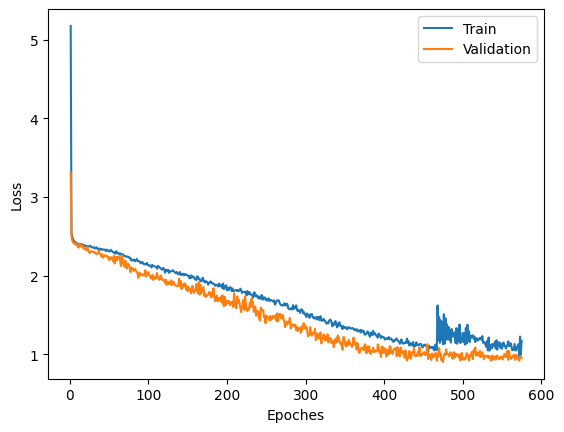

In [13]:
plot_loss(history)


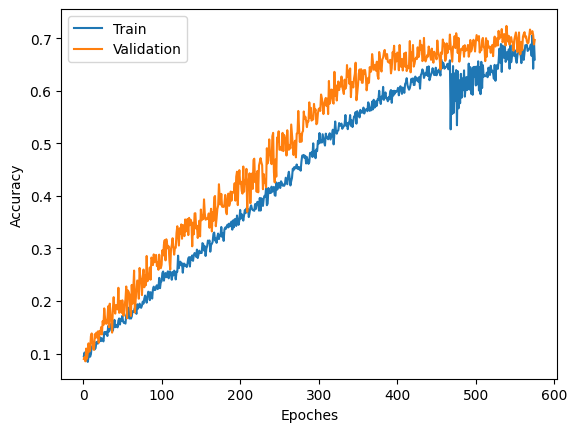

In [14]:
plot_acc(history)


## Testing


In [15]:
# model_path = "model/modelName/savedName.pth"
# bestd_model.load_state_dict(torch.load(model_path, map_location=device))


In [16]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
bestd_model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = bestd_model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())


  0%|          | 0/67 [00:00<?, ?it/s]

In [17]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in enumerate(predictions):
        f.write(f"{i},{pred}\n")
